# Paper Imports

In [2]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import multiprocess as mp
import pickle
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from coin import COIN
from environments import CustomMountainCarEnv
from rl import QLearningAgent, COINQLearningAgent

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Figure 1: Contextualisation and Clustering

## Plot effect of contextual policies on a training environment

In [ ]:
# Set scale factors for testing
sf = np.concatenate([
    0.0*np.ones((5000, )), 
    1.0*np.ones((5000, )),
    1.5*np.ones((5000, )),
    0.5*np.ones((5000, )),
    0.5*np.ones((5000, )),
    1.5*np.ones((5000, )),
    0.0*np.ones((5000, )),
    1.0*np.ones((5000, )),
    1.0*np.ones((5000, ))
    ])

train_basic = False # Set to True to train the models, otherwise load saved values
train_coin = False
train_oracle = False
train_optimal = False

MAX_CORES = 17
N_REPS = 100 # Number of repetitions of each model for averaging


### Basic no-context model.

In [ ]:
def run_single_rep(rep_id, sf):
    """
    Runs one repetition of training across all amplitudes in sf.
    Returns the list of rewards.
    """
    # Imports for multiprocessing
    from environments import CustomMountainCarEnv
    from rl import QLearningAgent
    # Create a fresh agent and environment inside each process

    env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
    agent = QLearningAgent(
        env=env,
        num_position_bins=30,
        num_velocity_bins=30,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.999,
        min_epsilon=0.01
    )

    rewards_for_this_rep = []
    for i, amplitude in enumerate(sf):
        # Create the environment for each amplitude
        env = CustomMountainCarEnv(amplitude=amplitude, render_mode="none")
        
        # Train the agent in the current context
        training_reward = agent.train_step(env=env, max_steps_per_episode=200)
        rewards_for_this_rep.append(training_reward)

        # Reset the environment epsilon at a change in amplitude
        if i > 0 and amplitude != sf[i - 1]:
            agent.epsilon = 1.0

        if (i + 1) % 500 == 0:
            print(f"Repetition {rep_id}, Amplitude {amplitude}: Training reward = {training_reward}")

    return rewards_for_this_rep

REWARDS_PATH = "models/fig1a_rewards_basic.npy"
if train_basic:
    # Number of repetitions and number of parallel processes:
    n_reps = N_REPS
    n_processes = MAX_CORES
        
    # Create a Pool of workers
    with mp.Pool(processes=n_processes) as pool:
        # Map each repetition to the function run_single_rep
        all_results = pool.starmap(run_single_rep, [(rep, sf) for rep in range(n_reps)])
        
    # all_results is a list of lists: one list of rewards for each repetition
    # Convert to a NumPy array, then average over axis=0 to get mean reward per amplitude
    all_results_array = np.array(all_results)  # shape: (n_reps, len(sf))
    rewards_basic = np.mean(all_results_array, axis=0)

    # Save results
    np.save(REWARDS_PATH, rewards_basic)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_basic = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")

### COIN Model

In [ ]:
COIN_PATH = "models/fig1a_coin_model_out.npy"

coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
)

if train_coin:
    # COIN model takes a long time to run - we simplify calculation here by assuming that 
    # the scale factor stays the same every 50 episodes.
    coin_model.perturbations = sf[::50]

    output = coin_model.simulate_coin()

    known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
    p_contexts = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1) 
    p_contexts = np.repeat(p_contexts, repeats=50, axis=0)

    # Ensure COIN probabilities are of the right form
    # Novel context - should never have a NaN definition
    p_temp = p_contexts.copy()
    p_temp[np.isnan(p_temp)] = 0.0
    p_contexts[:,-1] = 1 - np.sum(p_temp[:,:-1], axis=1)
    
    # Save coin model output
    np.save(COIN_PATH, p_contexts)
else:
    # Load the saved results from the training
    if os.path.exists(COIN_PATH):
        p_contexts = np.load(COIN_PATH)
        known_c_resp = p_contexts[:,:-1]
        novel_c_resp = p_contexts[:,-1]
        print(f"Loaded probabilities from '{COIN_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved probabilities found at '{COIN_PATH}'.")

In [ ]:
def run_single_rep(rep_id, sf, p_context):
    """
    Runs one repetition of training across all amplitudes in sf.
    Returns the list of rewards.
    """
    # Imports for multiprocessing
    from environments import CustomMountainCarEnv
    from rl import COINQLearningAgent
    # Create a fresh agent and environment inside each process

    C = p_context.shape[1]-1

    env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
    agent = COINQLearningAgent(
        env=env,
        max_contexts=C,
        num_position_bins=30,
        num_velocity_bins=30,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.999
    )

    rewards_for_this_rep = []
    for i, amplitude in enumerate(sf):
        # Create the environment for each amplitude
        env = CustomMountainCarEnv(amplitude=amplitude, render_mode="none")
        
        # Train the agent in the current context
        training_reward = agent.train_step(env=env, p_context=p_context[i,:], max_steps_per_episode=200)
        rewards_for_this_rep.append(training_reward)

        if (i + 1) % 500 == 0:
            print(f"Repetition {rep_id}, Amplitude {amplitude}: Training reward = {training_reward}")

    return rewards_for_this_rep

REWARDS_PATH = "models/fig1a_rewards_coin.npy"
if train_coin:
    # Number of repetitions and number of parallel processes:
    n_reps = N_REPS
    n_processes = MAX_CORES
        
    # Create a Pool of workers
    with mp.Pool(processes=n_processes) as pool:
        # Map each repetition to the function run_single_rep
        all_results = pool.starmap(run_single_rep, [(rep, sf, p_contexts) for rep in range(n_reps)])
        
    # all_results is a list of lists: one list of rewards for each repetition
    # Convert to a NumPy array, then average over axis=0 to get mean reward per amplitude
    all_results_array = np.array(all_results)  # shape: (n_reps, len(sf))
    rewards_coin = np.mean(all_results_array, axis=0)

    # Save results
    np.save(REWARDS_PATH, rewards_coin)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_coin = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")

### Oracle (True Context Known)

In [ ]:
REWARDS_PATH = "models/fig1a_rewards_oracle.npy"

# We use the COIN Q-learning framework, although with perfect context knowledge
p_contexts_oracle = np.zeros_like(p_contexts)
p_contexts_oracle[sf==0.0, 0] = 1.0
p_contexts_oracle[sf==0.5, 1] = 1.0
p_contexts_oracle[sf==1.0, 2] = 1.0
p_contexts_oracle[sf==1.5, 3] = 1.0
if train_oracle:
    # Number of repetitions and number of parallel processes:
    n_reps = N_REPS
    n_processes = MAX_CORES
        
    # Create a Pool of workers
    with mp.Pool(processes=n_processes) as pool:
        # Map each repetition to the function run_single_rep
        all_results = pool.starmap(run_single_rep, [(rep, sf, p_contexts_oracle) for rep in range(n_reps)])
        
    # all_results is a list of lists: one list of rewards for each repetition
    # Convert to a NumPy array, then average over axis=0 to get mean reward per amplitude
    all_results_array = np.array(all_results)  # shape: (n_reps, len(sf))
    rewards_oracle = np.mean(all_results_array, axis=0)

    # Save results
    np.save(REWARDS_PATH, rewards_oracle)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_oracle = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")

### Optimal Model

In [ ]:
if train_optimal:
    # Optimal model will train on the amplitude values for 30000 episodes
    envs = [CustomMountainCarEnv(amplitude=amp, render_mode="none") for amp in [0.0, 0.5, 1.0, 1.5]]
    agents = [QLearningAgent(
        env=envs[i],
        num_position_bins=30,
        num_velocity_bins=30,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.9999,
        min_epsilon=0.01
    ) for i in range(4)]

    rewards_optimal = []

    for i in range(4):
        # Create the MountainCar environment with the true amplitude
        env = envs[i]

        # Train the agent in the current context
        agent = agents[i]
        _, training_rewards = agent.train(
            env=env,
            max_steps_per_episode=200,
            n_episodes=30000,
        )

        rewards_optimal.append(np.max(training_rewards))

        # Print the average training reward every 500 episodes
        print(f"Agent {i+1}, Average Training reward: {np.mean(training_rewards[-1000:])}")

    for i in range(4):
        # Create the MountainCar environment with the true amplitude
        env = envs[i]

        # Evaluate the agent in the current context
        agent = agents[i]
        evaluation_reward = agent.evaluate(
            env=env,
            max_steps_per_episode=200,
            n_episodes=1,
        )

        # If evaluation_reward[0] > rewards_optimal[i], substitute:
        if evaluation_reward[0] > rewards_optimal[i]:
            rewards_optimal[i] = evaluation_reward[0]

        # Save results
        np.save("models/fig1a_rewards_optimal.npy", rewards_optimal)
        with open("models/fig1a_rewards_optimal.pkl", "wb") as f:
            pickle.dump(agents, f)
else:
    # Load the saved results from the training
    if os.path.exists("models/fig1a_rewards_optimal.npy"):
        rewards_optimal = np.load("models/fig1a_rewards_optimal.npy")
        print(f"Loaded rewards from 'models/fig1a_rewards_optimal.npy'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at 'models/fig1a_rewards_optimal.npy'.")
    if os.path.exists("models/fig1a_rewards_optimal.pkl"):
        with open("models/fig1a_rewards_optimal.pkl", "rb") as f:
            agents = pickle.load(f)
        print(f"Loaded agents from 'models/fig1a_rewards_optimal.pkl'.")
    else:
        raise FileNotFoundError(f"No saved agents found at 'models/fig1a_rewards_optimal.pkl'.")

### Figure 1a Plotting

In [ ]:
# Calculate regret for each different contextual model - specific to our data (not generalizable), here only for plotting
def calculate_regret(rewards, optimal_rewards, sf_assignment):
    """
    Calculate the regret for our scale factor data. Scale the regret to allow for better comparison.
    """
    regret = np.zeros_like(rewards)
    for i in range(len(optimal_rewards)):
        # Add the optimal reward for the corresponding amplitude
        regret[sf_assignment == i] = (-rewards[sf_assignment==i] + optimal_rewards[i])/(200+optimal_rewards[i])  
    return regret

sf_assignment = np.zeros_like(sf, dtype=int)
for i, amplitude in enumerate([0.0, 0.5, 1.0, 1.5]):
    sf_assignment[sf == amplitude] = i
regret_basic = calculate_regret(rewards_basic, rewards_optimal, sf_assignment)
regret_coin = calculate_regret(rewards_coin, rewards_optimal, sf_assignment)
regret_oracle = calculate_regret(rewards_oracle, rewards_optimal, sf_assignment)

# Plot smooth versions of the regrets
regret_basic_s = np.convolve(regret_basic,np.ones(50,)/50, mode='same')
regret_coin_s = np.convolve(regret_coin,np.ones(50,)/50, mode='same')
regret_oracle_s = np.convolve(regret_oracle,np.ones(50,)/50, mode='same')

# Tableau color palette
tableau_colors = plt.get_cmap("tab10").colors
color_basic = tableau_colors[0]   # blue
color_coin = tableau_colors[1]    # orange
color_oracle = tableau_colors[2]  # green

# Font setup
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 13,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Plot
plt.figure(figsize=(6.5, 4))
plt.plot(regret_basic_s, label='Basic', color=color_basic, linewidth=1.8)
plt.plot(regret_coin_s, label='COIN', color=color_coin, linewidth=1.8, linestyle='--')
plt.plot(regret_oracle_s, label='Oracle', color=color_oracle, linewidth=1.8, linestyle=':')

plt.ylim(-0.0, 1.2)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=12)
xticks = np.arange(0, len(regret_basic_s)+1, 5000)
plt.xticks(xticks)

# Labels and legend
plt.xlabel('Episode')
plt.ylabel('Regret (Normalised)')
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 0.99),
    ncol=3,
    frameon=True,
    fancybox=False,
    facecolor='white',
    edgecolor='black'
)

# Tidy up
plt.tight_layout()
# Hide every other label
ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    if int(label.get_text()) % 10000 != 0:
        label.set_visible(False)
plt.savefig('figures/fig1a_regret.svg', dpi=300, bbox_inches='tight')  # Save as PDF for high quality
plt.show()

# Parameter variation plot
plt.figure(figsize=(6.5, 3))
plt.plot(sf, color='firebrick', linewidth=2.2, label='Scale Factor (sf)')

plt.xlabel('Episode')
plt.ylabel('Scale Factor')

plt.yticks(np.array([0.0, 1.0, 1.5, 0.5]), fontsize=12)
xticks = np.arange(0, len(regret_basic_s)+1, 5000)
plt.xticks(xticks)

plt.tight_layout()
ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    if int(label.get_text()) % 10000 != 0:
        label.set_visible(False)
plt.savefig('figures/fig1a_parameter.svg', dpi=300, bbox_inches='tight')
plt.show()

# plt.figure(figsize=(10,6))
# plt.plot(sf)

# plt.figure(figsize=(10,6))
# plt.plot(p_contexts[:,:-1])

# plt.figure(figsize=(10,6))
# plt.plot(p_contexts_oracle[:,:-1])


## Plot different clustering models
Set up data

In [ ]:
# Data to cluster
data = np.concatenate([
    0.0*np.ones((100,)),
    1.0*np.ones((100,)),
    -1.0*np.ones((100,)),
    np.linspace(-1.0,1.0,100),
    0.5*np.ones((100,)),
    0.0*np.ones((100,)),
])

# Number of clusters (does not apply to COIN)
K = 4

# Figure sizes
fig1bsize = (5.5, 2.0)

# Font setup
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "legend.fontsize": 13,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

# Plot variation
plt.figure(figsize=fig1bsize)
plt.plot(data, color='firebrick', linewidth=2.2, label='Scale Factor (sf)')

plt.ylabel('Parameter')

plt.yticks(np.array([-1.0, -0.5, 0.0, 0.5, 1.0]), fontsize=12)
xticks = np.arange(0, len(data)+1, 50)
plt.xticks(xticks)

plt.tight_layout()
ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    if int(label.get_text()) % 100 != 0:
        label.set_visible(False)
plt.savefig('figures/fig1b_parameter.svg', dpi=300, bbox_inches='tight')
plt.show()

### K-Means

In [ ]:
def _kmeans_pp_init(x: np.ndarray, K: int, rng: np.random.Generator):
    """k‑means++ initialisation for 1‑D data (returns K starting centroids)."""
    centroids = np.empty(K, dtype=x.dtype)
    centroids[0] = rng.choice(x)

    # Squared distances to the closest chosen centroid
    d2 = (x - centroids[0]) ** 2

    for k in range(1, K):
        probs = d2 / d2.sum()
        centroids[k] = rng.choice(x, p=probs)
        d2 = np.minimum(d2, (x - centroids[k]) ** 2)

    return centroids


def kmeans_1d(
    P,
    K: int,
    max_iter: int = 100,
    tol: float = 1e-4,
    seed: int | None = None,
    verbose: bool = False,
):
    """
    Clusters 1‑D data P into K groups.

    Parameters
    ----------
    P : array‑like shape (N,)
        The data points (floats or ints).
    K : int
        Number of clusters.
    max_iter : int
        Maximum number of Expectation–Maximisation iterations.
    tol : float
        Convergence threshold on centroid shift.
    seed : int or None
        RNG seed for reproducibility.
    verbose : bool
        If True, prints loss and centroid shift each iteration.

    Returns
    -------
    labels : ndarray shape (N,)
        Cluster index (0..K‑1) for every point in P.
    centroids : ndarray shape (K,)
        Final centroid positions.
    """
    # --- prepare data & RNG ---
    x = np.asarray(P, dtype=float).ravel()
    N = x.size
    rng = np.random.default_rng(seed)

    # --- initial centroids ---
    centroids = _kmeans_pp_init(x, K, rng)

    for it in range(1, max_iter + 1):
        # ----- E‑step: assign each point to nearest centroid -----
        distances = np.abs(x[:, None] - centroids[None, :])  # (N, K)
        labels = distances.argmin(axis=1)                   # (N,)

        # ----- M‑step: recompute centroids (mean of assigned points) -----
        new_centroids = np.empty_like(centroids)
        for k in range(K):
            points_k = x[labels == k]
            # handle empty cluster ⇒ re‑initialise to random point
            new_centroids[k] = points_k.mean() if points_k.size else rng.choice(x)

        # ----- check convergence -----
        shift = np.abs(new_centroids - centroids).max()
        if verbose:
            inertia = ((x - new_centroids[labels]) ** 2).sum()
            print(f"iter {it:03d}  inertia={inertia:,.3f}  shift={shift:.5f}")
        if shift < tol:
            break
        centroids = new_centroids

    return labels, centroids

# Run k-means clustering
labels_kmeans, centroids_kmeans = kmeans_1d(data, K=K, verbose=False)


In [ ]:
# Set up figure and font
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 13,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

def remap_labels_by_first_appearance(labels):
    label_map = {}
    new_labels = []
    next_label = 1
    for label in labels:
        if label not in label_map:
            label_map[label] = next_label
            next_label += 1
        new_labels.append(label_map[label])
    return np.array(new_labels)

# Remap labels
labels_kmeans = remap_labels_by_first_appearance(labels_kmeans)

# Sorted unique labels (in case k-means returned [2, 0, 1] etc.)
unique_labels = np.unique(labels_kmeans)
K = len(unique_labels)
cmap = plt.get_cmap('tab10')
label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

# Colors for each point in correct label order
point_colors = [label_to_color[label] for label in labels_kmeans]

# Create figure
plt.figure(figsize=fig1bsize)
scatter = plt.scatter(
    np.arange(data.size),
    data,
    c=point_colors,
    s=60,
    edgecolors='none'
)

plt.ylabel('Parameter')
plt.yticks(np.array([-1.0, -0.5, 0.0, 0.5, 1.0]), fontsize=12)
plt.xticks(np.arange(0, len(data)+1, 50))

# Manual legend with synced colors
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=f'C{i+1}',
               markerfacecolor=cmap(i), markeredgecolor='none', markersize=8)
    for i in range(K)
]

plt.legend(
    handles=handles,
    title='Context',
    loc='lower right',
    ncol=2,
    frameon=True,
    framealpha=1.0,
    facecolor='white',
    edgecolor='black',
    columnspacing=0.8
)

plt.tight_layout()
ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    if int(label.get_text()) % 100 != 0:
        label.set_visible(False)

plt.savefig('figures/fig1b_kmeans.svg', dpi=300, bbox_inches='tight')
plt.show()



### GMMs

In [ ]:
import numpy as np
from numpy.random import default_rng
from math import log, pi


# ---------- utilities ---------------------------------------------------------
def _log_gaussian(x, mu, var):
    """log 𝒩(x | μ, σ²) — vectorised over x."""
    return -0.5 * (np.log(2 * pi * var) + (x - mu) ** 2 / var)


def _kmeans_pp_init(x, K, rng):
    """1‑D k‑means++ initial means (returns sorted for convenience)."""
    means = np.empty(K, dtype=x.dtype)
    means[0] = rng.choice(x)
    d2 = (x - means[0]) ** 2
    for k in range(1, K):
        probs = d2 / d2.sum()
        means[k] = rng.choice(x, p=probs)
        d2 = np.minimum(d2, (x - means[k]) ** 2)
    return np.sort(means)


# ---------- deterministic‑annealing EM ---------------------------------------
def gmm_1d_da(x, K, anneal_schedule, max_iter=60, tol=1e-5, rng=None, verbose=0):
    """
    One run of EM with an annealing schedule β₁…β_M (0<β<=1).
    Returns (logL, labels, π, μ, var).
    """
    if rng is None:
        rng = default_rng()
    N = x.size

    # initial parameters -------------------------------------------------------
    mu = _kmeans_pp_init(x, K, rng)
    var = np.full(K, x.var() + 1e-6)
    pi = np.full(K, 1.0 / K)

    def e_step(beta):
        # responsibilities γᵢₖ ∝ (πₖ 𝒩)ᵝ
        log_prob = beta * (_log_gaussian(x[:, None], mu, var) + np.log(pi))
        log_tot = log_prob.max(axis=1, keepdims=True) + np.log(
            np.exp(log_prob - log_prob.max(axis=1, keepdims=True)).sum(axis=1, keepdims=True)
        )
        resp = np.exp(log_prob - log_tot)
        return resp, log_tot.sum() / beta          # true log‑likelihood (β cancels)

    # annealing loop -----------------------------------------------------------
    prev_ll = -np.inf
    for beta in anneal_schedule:
        for _ in range(max_iter):
            resp, ll = e_step(beta)
            Nk = resp.sum(axis=0) + 1e-10
            pi = Nk / N
            mu = (resp.T @ x) / Nk
            diff2 = (x[:, None] - mu) ** 2
            var = (resp * diff2).sum(axis=0) / Nk
            var = np.clip(var, 1e-6, None)

            if ll - prev_ll < tol:
                break
            prev_ll = ll
        if verbose:
            print(f"β={beta:.2f}  iter≤{max_iter}  logL={ll:.4f}")

    labels = resp.argmax(axis=1)
    return ll, labels, pi, mu, var


# ---------- multi‑start wrapper ----------------------------------------------
def gmm_1d_robust(
    P,
    K: int,
    restarts: int = 10,
    anneal_schedule: list[float] | None = None,
    max_iter: int = 60,
    tol: float = 1e-5,
    seed: int | None = None,
    verbose: bool = False,
):
    """
    Robust GMM clustering.

    Parameters
    ----------
    P                : 1‑D data (array‑like)
    K                : number of components
    restarts         : how many independent runs to try
    anneal_schedule  : list of β values. e.g. [0.2,0.4,0.6,0.8,1.0].
                       None → plain EM (β=1).
    max_iter, tol    : inner EM settings
    seed             : RNG seed
    verbose          : print progress

    Returns
    -------
    best_labels, best_pi, best_mu, best_var
    """
    x = np.asarray(P, dtype=float).ravel()
    rng_master = default_rng(seed)

    if anneal_schedule is None:
        anneal_schedule = [1.0]                     # plain EM

    best_ll = -np.inf
    best_res = None

    for r in range(restarts):
        rng = default_rng(rng_master.integers(1 << 32))
        ll, labels, pi, mu, var = gmm_1d_da(
            x,
            K,
            anneal_schedule,
            max_iter=max_iter,
            tol=tol,
            rng=rng,
            verbose=(verbose and restarts > 1),
        )
        if verbose and restarts > 1:
            print(f"restart {r+1}/{restarts}  final logL={ll:.4f}")

        if ll > best_ll:
            best_ll = ll
            best_res = (labels, pi, mu, var)

    if verbose and restarts > 1:
        print(f"best logL={best_ll:.4f}")

    return best_res  # unpack as needed


# -------------------------- demo ---------------------------------------------
rng = default_rng(23)
labels_gmm, pi_gmm, mu_gmm, var_gmm  = gmm_1d_robust(
    data,
    K=K,
    max_iter=2000,
    restarts=10,
    anneal_schedule=[1.0],
    verbose=True,
)


In [ ]:
# === Compute GMM likelihoods ===
likel = np.vstack([
    pi_gmm[k] * np.exp(_log_gaussian(data, mu_gmm[k], var_gmm[k]))
    for k in range(K)
])
likel = likel / np.sum(likel, axis=0)

# === Get hard labels from GMM (most likely component per point) ===
label_gmm_raw = np.argmax(likel, axis=0)

# === Remap labels by first appearance (starting from 1) ===
def remap_labels_by_first_appearance(labels):
    label_map = {}
    new_labels = []
    next_label = 1
    for label in labels:
        if label not in label_map:
            label_map[label] = next_label
            next_label += 1
        new_labels.append(label_map[label])
    return np.array(new_labels), label_map

label_gmm, label_map = remap_labels_by_first_appearance(label_gmm_raw)

# === Invert label_map to get permutation index ===
# label_map: {original_label -> new_label}
# We want perm[new_label - 1] = original_label
perm = [None] * len(label_map)
for original_label, new_label in label_map.items():
    perm[new_label - 1] = original_label
perm = np.array(perm)

# === Permute `likel` so that its rows follow the remapped order ===
likel = likel[perm, :]


# Font and figure styling
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 13,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

# Start figure
plt.figure(figsize=fig1bsize)
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(K)]

# Plot each component's likelihood
for k in range(K):
    plt.plot(likel[k, :], color=colors[k], linewidth=1.6)

# Axis formatting
plt.ylabel('Likelihood')
plt.xticks(np.arange(0, likel.shape[1]+1, 50))
plt.yticks(np.linspace(0, 1, 5))

# Tight layout & clean x-tick labeling
plt.tight_layout()
ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    if int(label.get_text()) % 100 != 0:
        label.set_visible(False)

plt.savefig('figures/fig1b_gmm.svg', dpi=300, bbox_inches='tight')
plt.show()



### Mutual Information

In [ ]:
class InfoMax1DClusterer(nn.Module):
    """Small MLP that acts as a discriminator q_theta(y|x)."""
    def __init__(self, K: int, hidden: int = 32):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, K)
        )

    def forward(self, x):
        logits = self.net(x)
        return torch.softmax(logits, dim=1)      # q_theta(y|x)


def mutual_information_loss(q_batch: torch.Tensor, eps: float = 1e-10):
    """
    -I(X;Y) Estimator (negative for optimisation).
    q_batch  : (B, K) distributions q_theta(y|x) for a minibatch.
    """
    # Pseudo-counts of clusters in the batch
    p_y = q_batch.mean(dim=0)                    # (K,)
    H_y = -(p_y * (p_y + eps).log()).sum()

    H_y_given_x = -(q_batch * (q_batch + eps).log()).sum(dim=1).mean()

    return -(H_y - H_y_given_x)


def fit_infomax(P, K=3, epochs=500, batch_size=128, lr=1e-3, seed=0,
                verbose=True):
    """
    Train the discriminator and develop clustering indices for each point.
    P          : array‑like unidimensional (n_samples,)
    K          : cluster count
    epochs     : training iterations
    batch_size : minibatch size
    lr         : learning rate Adam
    seed       : reproducibility
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    # ----- Prepare data -----
    x = np.asarray(P, dtype=np.float32).reshape(-1, 1)
    dataset = TensorDataset(torch.tensor(x))
    loader = DataLoader(dataset, batch_size=min(batch_size, len(x)),
                        shuffle=True, drop_last=False)

    # ----- Model and optimiser -----
    model = InfoMax1DClusterer(K)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    # ----- Training -----
    for epoch in range(1, epochs + 1):
        for (batch,) in loader:
            q = model(batch)
            loss = mutual_information_loss(q)
            opt.zero_grad()
            loss.backward()
            opt.step()
        if verbose and epoch % max(1, epochs // 10) == 0:
            print(f"Epoch {epoch:>4}/{epochs},  –I(X;Y) ≈ {loss.item():.4f}")

    # ----- Assign final tags -----
    with torch.no_grad():
        q_all = model(torch.tensor(x))
        labels = torch.argmax(q_all, dim=1).cpu().numpy()

    return labels, model


labels, model = fit_infomax(data, K=K, epochs=300)
print("Assigned classes (first 20):", labels[:20])


In [ ]:
# Obtain probabilities for each class
x = np.asarray(data, dtype=np.float32).reshape(-1, 1)
q_all = model(torch.Tensor(x))
q_all = q_all.cpu().detach().numpy().transpose()

label_mi_raw = np.argmax(q_all, axis=0)

# === Remap labels by first appearance (starting from 1) ===
def remap_labels_by_first_appearance(labels):
    label_map = {}
    new_labels = []
    next_label = 1
    for label in labels:
        if label not in label_map:
            label_map[label] = next_label
            next_label += 1
        new_labels.append(label_map[label])
    return np.array(new_labels), label_map

label_mi, label_map = remap_labels_by_first_appearance(label_mi_raw)

# === Invert label_map to get permutation index ===
# label_map: {original_label -> new_label}
# We want perm[new_label - 1] = original_label
perm = [None] * len(label_map)
for original_label, new_label in label_map.items():
    perm[new_label - 1] = original_label
perm = np.array(perm)

q_all = q_all[perm, :]


# Font and figure styling
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 13,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

# Start figure
plt.figure(figsize=fig1bsize)
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(K)]

# Plot each component's likelihood
for k in range(K):
    plt.plot(q_all[k, :], color=colors[k], linewidth=1.6)

# Axis formatting
plt.ylabel('Likelihood')
plt.xticks(np.arange(0, likel.shape[1]+1, 50))
plt.yticks(np.linspace(0, 1, 5))

# Tight layout & clean x-tick labeling
plt.tight_layout()
ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    if int(label.get_text()) % 100 != 0:
        label.set_visible(False)

plt.savefig('figures/fig1b_mi.svg', dpi=300, bbox_inches='tight')
plt.show()


### COIN

In [ ]:
# Use COIN to classify the data - here we use the retention model

coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
)

coin_model.perturbations = data

output = coin_model.simulate_coin()

known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
p_contexts = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1) 

In [ ]:
coin_known = known_c_resp.transpose()
label_coin_raw = np.argmax(coin_known, axis=0)

# === Remap labels by first appearance (starting from 1) ===
def remap_labels_by_first_appearance(labels):
    label_map = {}
    new_labels = []
    next_label = 1
    for label in labels:
        if label not in label_map:
            label_map[label] = next_label
            next_label += 1
        new_labels.append(label_map[label])
    return np.array(new_labels), label_map

label_coin, label_map = remap_labels_by_first_appearance(label_coin_raw)

# === Invert label_map to get permutation index ===
# label_map: {original_label -> new_label}
# We want perm[new_label - 1] = original_label
perm = [None] * len(label_map)
for original_label, new_label in label_map.items():
    perm[new_label - 1] = original_label
perm = np.array(perm)

# === Permute `likel` so that its rows follow the remapped order ===
coin_known = coin_known[perm, :]


# Font and figure styling
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 13,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "legend.fontsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11
})

# Start figure
plt.figure(figsize=fig1bsize)
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(K+1)]

# Plot each component's likelihood
for k in range(K):
    plt.plot(coin_known[k, :], color=colors[k], linewidth=1.6)

# Plot COIN novel context line with label
plt.plot(novel_c_resp, color=colors[-1], linewidth=1.6, linestyle='--', label='Novel\nContext')

# Add single-item compact legend at middle right
plt.legend(
    loc='center right',
    frameon=True,
    facecolor='white',
    edgecolor='black',
    handlelength=2.0
)

# Axis formatting
plt.ylabel('Likelihood')
plt.xlabel('Episode')
plt.xticks(np.arange(0, likel.shape[1]+1, 50))
plt.yticks(np.linspace(0, 1, 5))

# Tight layout & clean x-tick labeling
plt.tight_layout()
ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    if int(label.get_text()) % 100 != 0:
        label.set_visible(False)

plt.savefig('figures/fig1b_coin.svg', dpi=300, bbox_inches='tight')
plt.show()

# Figure 2: Model Comparison and Generalisation

## Plot Comparison between different contextual approaches on fixed dataset

### Data Preparation

In [ ]:
mc_1 = np.concatenate([
    0.0*np.ones((3,)),
    1.0*np.ones((3,)),
    0.0*np.ones((2,)),
    1.0*np.ones((2,)),
    1.5*np.ones((2,)),
    0.0*np.ones((2,)),
    1.5*np.ones((3,)),
    1.0*np.ones((1,)),
    0.5*np.ones((2,)),
]) # First data for Mountain Car

mc_1 = np.repeat(mc_1, 1000, axis=0)

mc1_gen = np.linspace(0.0,1.5,20) # Data to test generalisation

# Train or load
train_mc1 = False

### COIN - Mountain Car 1

In [ ]:
# Train COIN Model
coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
)

coin_model.perturbations = mc_1[::100]

output = coin_model.simulate_coin()

known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
p_contexts = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1) 

# Ensure COIN probabilities are of the right form
# Novel context - should never have a NaN definition
p_temp = p_contexts.copy()
p_temp[np.isnan(p_temp)] = 0.0
p_contexts[:,-1] = 1 - np.sum(p_temp[:,:-1], axis=1) # This variable has size [T,C]. It should be used for TRAINING, passed into the p_context parameter


pred_resp = coin_model.get_predicted_responsibilities(output, mc1_gen) #This has size [N,T,C] - for gen_val. Each evaluation takes a new value of size [N,C].

# Ensure interpolation of probabilities back to appropriate size
p_contexts = np.repeat(p_contexts, repeats=100, axis=0)
pred_resp = np.repeat(pred_resp, repeats=100, axis=1)

In [ ]:
def run_single_rep(rep_id, sf, p_context, gen_val, pred_resp):
    """
    Runs one repetition of training across all amplitudes in sf. After every training step, evaluate for every 
    amplitude in gen_val.
    Returns the list of rewards for the evaluation steps.
    """
    # Imports for multiprocessing
    from environments import CustomMountainCarEnv
    from rl import COINQLearningAgent
    import numpy as np
    from tqdm.notebook import tqdm
    # Create a fresh agent and environment inside each process

    C = p_context.shape[1]-1

    env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
    agent = COINQLearningAgent(
        env=env,
        max_contexts=C,
        num_position_bins=30,
        num_velocity_bins=30,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.999
    )

    rewards_for_this_rep = []
    training_rewards_for_this_rep = []
    evaluation_rewards_for_this_rep = []
    for t, amplitude in tqdm(enumerate(sf), total=len(sf)):
        # Create the environment for each amplitude
        env = CustomMountainCarEnv(amplitude=amplitude, render_mode="none")
        
        # Train the agent in the current context
        training_reward = agent.train_step(env=env, p_context=p_context[t,:], max_steps_per_episode=200)
        training_rewards_for_this_rep.append(training_reward)

        eval_r = agent.evaluate(env, p_context=p_context[t,:], n_episodes=1)[0]
        evaluation_rewards_for_this_rep.append(eval_r)
          
        # Evaluate for all the gen_val
        evaluation_rewards = np.zeros((gen_val.size,))

        if t==0 or t % 500 == 0:
            for i in range(evaluation_rewards.size):
                eval_amp = gen_val[i]
                env = CustomMountainCarEnv(amplitude=eval_amp, render_mode="none")

                evaluation_rewards[i] = np.mean(agent.evaluate(env, pred_resp[i,t,:], 10, 200, True)[0])
            rewards_for_this_rep.append(evaluation_rewards)

    return np.stack(rewards_for_this_rep), np.stack(training_rewards_for_this_rep), np.stack(evaluation_rewards_for_this_rep)



In [ ]:
REWARDS_PATH = 'models/fig2a_rewards_mc1_coin.npy'
if train_mc1:
    all_results = run_single_rep(1, mc_1, p_contexts, mc1_gen, pred_resp)

    rewards_mc1_coin = all_results[0]

    # Save results
    np.save(REWARDS_PATH, rewards_mc1_coin)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
        
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_mc1_coin = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")    

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# Normalize data
data = rewards_mc1_coin
data = (data - data.min()) / (data.max() - data.min())
N, B = data.shape

# ── Mask out zeros ─────────────────────────────────────────────────
masked_data = np.ma.masked_where(data == 0, data)

# ── Create a modified colormap where masked values (==0) appear black ─
cmap = plt.get_cmap('viridis')
cmap_with_black = cmap.copy()
cmap_with_black.set_bad(color='black')  # set color for masked values

# ── Plot ────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.imshow(masked_data,
                origin='upper',
                aspect='auto',
                interpolation='nearest',
                vmin=0,
                vmax=1,
                cmap=cmap_with_black)

# ── Training data markers ───────────────────────────────────────────
d = mc_1[::500]
col_indices = np.rint((d - mc1_gen.min())/(mc1_gen.max() - mc1_gen.min())*(mc1_gen.size - 1)).astype(int)
row_indices = np.arange(N)

ax.scatter(col_indices, row_indices,
           facecolors='red',
           edgecolors='white',
           s=50,
           linewidths=2,
           marker='o')

# ── Colorbar & labels ───────────────────────────────────────────────
fig.colorbar(cax, ax=ax, label='Return (Scaled)')
ax.set_xlabel('Parameter Value')
ax.set_ylabel('Episode')

# ── Ticks ───────────────────────────────────────────────────────────
ax.set_xticks(np.arange(0,B,2))
ax.set_yticks(np.arange(0, N, 5))
ax.set_xticklabels([f"{float(v):.2f}" for v in mc1_gen[::2]])
ax.set_yticklabels(np.arange(0, len(mc_1), 2500))

plt.tight_layout()
plt.savefig('figures/fig2a_coin_mc1.svg', dpi=300, bbox_inches='tight')
plt.show()


### K-Means: Mountain Car 1

In [ ]:
from utils.clustering import kmeans_1d

K = 4
data = mc_1

# Run k-means clustering
labels_kmeans, centroids_kmeans = kmeans_1d(mc_1, K=K, verbose=False)

# We use the COIN Q-learning framework, although with perfect context knowledge
p_contexts_kmeans = np.zeros((data.shape[0],5))
p_contexts_kmeans[labels_kmeans==0,0] = 1.0
p_contexts_kmeans[labels_kmeans==1,1] = 1.0
p_contexts_kmeans[labels_kmeans==2,2] = 1.0
p_contexts_kmeans[labels_kmeans==3,3] = 1.0

# Predictive responsibilities from k-means simply finds the closest context
test_labels = np.argmin(np.abs(mc1_gen[:, None] - centroids_kmeans[None, :]), axis=1)

pred_resp_k = np.zeros((test_labels.shape[0],5))
pred_resp_k[test_labels==0,0] = 1.0
pred_resp_k[test_labels==1,1] = 1.0
pred_resp_k[test_labels==2,2] = 1.0
pred_resp_k[test_labels==3,3] = 1.0

pred_resp_k = pred_resp_k[:,None,:]
pred_resp_k = np.repeat(pred_resp_k, data.shape[0], axis=1)

REWARDS_PATH = 'models/fig2a_rewards_mc1_kmeans.npy'
if train_mc1:
    # Number of repetitions and number of parallel processes:
    n_reps = 1
    n_processes = 1
        
    # Run tests
    all_results = run_single_rep(1, mc_1, p_contexts_kmeans, mc1_gen, pred_resp_k)

    rewards_mc1_kmeans = all_results[0]

    # Save results
    np.save(REWARDS_PATH, rewards_mc1_kmeans)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
        
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_mc1_kmeans = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")   


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# ── Prepare data ──────────────────────────────────────────────────────
data = rewards_mc1_kmeans
data = (data - data.min()) / (data.max() - data.min())  # normalize
N, B = data.shape

# ── Mask zeros ────────────────────────────────────────────────────────
masked_data = np.ma.masked_where(data == 0, data)

# ── Use viridis colormap but set 'bad' values (masked) to black ───────
cmap = plt.get_cmap('viridis').copy()
cmap.set_bad(color='black')

# ── Plot heatmap ──────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.imshow(masked_data,
                origin='upper',
                aspect='auto',
                interpolation='nearest',
                vmin=0,
                vmax=1,
                cmap=cmap)

# ── Highlight training data positions ─────────────────────────────────
d = mc_1[::500]
col_indices = np.rint((d - mc1_gen.min()) / (mc1_gen.max() - mc1_gen.min()) * (mc1_gen.size - 1)).astype(int)
row_indices = np.arange(N)

ax.scatter(col_indices, row_indices,
           facecolors='red',
           edgecolors='white',
           s=50,
           linewidths=2,
           marker='o')

# ── Labels, ticks, and colorbar ───────────────────────────────────────
fig.colorbar(cax, ax=ax, label='Return (Scaled)')
ax.set_xlabel('Parameter Value')
ax.set_ylabel('Episode')

ax.set_xticks(np.arange(0,B,2))
ax.set_yticks(np.arange(0, N, 5))
ax.set_xticklabels([f"{float(v):.2f}" for v in mc1_gen[::2]])
ax.set_yticklabels(np.arange(0, len(mc_1), 2500))

plt.tight_layout()
plt.savefig('figures/fig2a_kmeans_mc1.svg', dpi=300, bbox_inches='tight')
plt.show()


## Scaffolding

In [ ]:
# Set up data for scaffolding test
mc_2 = np.concatenate([
    np.ones((5,)),
    np.linspace(1.0, 1.8, 20),
])

mc_2 = np.repeat(mc_2, 500, axis=0)

eps_decay = 1/mc_2.size * np.log(1.0/0.01)

mc2_gen = np.linspace(1.0,1.8,21) # Data to test generalisation

# Train or load
train_mc2 = False

### COIN - Mountain Car 2

In [ ]:
# Train COIN Model
coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
)

coin_model.perturbations = mc_2[::100]

output = coin_model.simulate_coin()

known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
p_contexts = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1) 

# Ensure COIN probabilities are of the right form
# Novel context - should never have a NaN definition
p_temp = p_contexts.copy()
p_temp[np.isnan(p_temp)] = 0.0
p_contexts[:,-1] = 1 - np.sum(p_temp[:,:-1], axis=1) # This variable has size [T,C]. It should be used for TRAINING, passed into the p_context parameter


pred_resp = coin_model.get_predicted_responsibilities(output, mc2_gen) #This has size [N,T,C] - for gen_val. Each evaluation takes a new value of size [N,C].

# Ensure interpolation of probabilities back to appropriate size
p_contexts = np.repeat(p_contexts, repeats=100, axis=0)
pred_resp = np.repeat(pred_resp, repeats=100, axis=1)

In [ ]:
def run_single_rep(rep_id, sf, p_context, gen_val, pred_resp):
    """
    Runs one repetition of training across all amplitudes in sf. After every training step, evaluate for every 
    amplitude in gen_val.
    Returns the list of rewards for the evaluation steps.
    """
    # Imports for multiprocessing
    from environments import CustomMountainCarEnv
    from rl import COINQLearningAgent
    import numpy as np
    from tqdm.notebook import tqdm
    # Create a fresh agent and environment inside each process

    C = p_context.shape[1]-1

    env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
    agent = COINQLearningAgent(
        env=env,
        max_contexts=C,
        num_position_bins=30,
        num_velocity_bins=30,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=eps_decay
    )

    rewards_for_this_rep = []
    training_rewards_for_this_rep = []
    evaluation_rewards_for_this_rep = []
    for t, amplitude in tqdm(enumerate(sf), total=len(sf)):
        # Create the environment for each amplitude
        env = CustomMountainCarEnv(amplitude=amplitude, render_mode="none")
        
        # Train the agent in the current context
        training_reward = agent.train_step(env=env, p_context=p_context[t,:], max_steps_per_episode=200)
        training_rewards_for_this_rep.append(training_reward)

        eval_r = agent.evaluate(env, p_context=p_context[t,:], n_episodes=1)[0]
        evaluation_rewards_for_this_rep.append(eval_r)
          
        # Evaluate for all the gen_val
        evaluation_rewards = np.zeros((gen_val.size,))

        if t==0 or t % 500 == 0:
            for i in range(evaluation_rewards.size):
                eval_amp = gen_val[i]
                env = CustomMountainCarEnv(amplitude=eval_amp, render_mode="none")

                evaluation_rewards[i] = np.mean(agent.evaluate(env, pred_resp[i,t,:], 10, 200, True)[0])
            rewards_for_this_rep.append(evaluation_rewards)

    return np.stack(rewards_for_this_rep), np.stack(training_rewards_for_this_rep), np.stack(evaluation_rewards_for_this_rep)



In [ ]:
REWARDS_PATH = 'models/fig2a_rewards_mc2_coin.npy'
if train_mc2:
    all_results = run_single_rep(1, mc_2, p_contexts, mc2_gen, pred_resp)

    rewards_mc2_coin = all_results[0]

    # Save results
    np.save(REWARDS_PATH, rewards_mc2_coin)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
        
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_mc2_coin = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")    

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(mc2_gen,pred_resp[:,-1,1])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# ── Normalize and mask zero entries ─────────────────────────────────────
data = rewards_mc2_coin
data = (data - data.min()) / (data.max() - data.min())
masked_data = np.ma.masked_where(data == 0, data)
N, B = data.shape

# ── Create modified colormap with black for masked values ───────────────
cmap = plt.get_cmap('viridis').copy()
cmap.set_bad(color='black')

# ── Create figure and axes ──────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

# ── Plot heatmap ────────────────────────────────────────────────────────
cax = ax.imshow(masked_data,
                origin='upper',
                aspect='auto',
                interpolation='nearest',
                vmin=0,
                vmax=1,
                cmap=cmap)

# ── Highlight training data ─────────────────────────────────────────────
d = mc_2[::500]
col_indices = np.rint((d - mc2_gen.min()) / (mc2_gen.max() - mc2_gen.min()) * (mc2_gen.size - 1)).astype(int)
row_indices = np.arange(N)

ax.scatter(col_indices, row_indices,
           facecolors='red',
           edgecolors='white',
           s=50,
           linewidths=2,
           marker='o')

# ── Labels, ticks, colorbar ─────────────────────────────────────────
fig.colorbar(cax, ax=ax, label='Return (Scaled)')
ax.set_xlabel('Parameter Value')
ax.set_ylabel('Episode')

ax.set_xticks(np.arange(0, B, 2))
ax.set_yticks(np.arange(0, N, 5))
ax.set_xticklabels([f"{float(v):.2f}" for v in mc2_gen[::2]])
ax.set_yticklabels(np.arange(0, len(mc_2), 2500))

plt.tight_layout()
plt.savefig('figures/fig2a_coin_mc2.svg', dpi=300, bbox_inches='tight')
plt.show()


### K-Means: Mountain Car 2

In [ ]:
from utils.clustering import kmeans_1d

K = 4
data = mc_2

# Run k-means clustering
labels_kmeans, centroids_kmeans = kmeans_1d(mc_2, K=K, verbose=False)

# We use the COIN Q-learning framework, although with perfect context knowledge
p_contexts_kmeans = np.zeros((data.shape[0],5))
p_contexts_kmeans[labels_kmeans==0,0] = 1.0
p_contexts_kmeans[labels_kmeans==1,1] = 1.0
p_contexts_kmeans[labels_kmeans==2,2] = 1.0
p_contexts_kmeans[labels_kmeans==3,3] = 1.0

# Predictive responsibilities from k-means simply finds the closest context
test_labels = np.argmin(np.abs(mc2_gen[:, None] - centroids_kmeans[None, :]), axis=1)

pred_resp_k = np.zeros((test_labels.shape[0],5))
pred_resp_k[test_labels==0,0] = 1.0
pred_resp_k[test_labels==1,1] = 1.0
pred_resp_k[test_labels==2,2] = 1.0
pred_resp_k[test_labels==3,3] = 1.0

pred_resp_k = pred_resp_k[:,None,:]
pred_resp_k = np.repeat(pred_resp_k, data.shape[0], axis=1)

REWARDS_PATH = 'models/fig2a_rewards_mc2_kmeans.npy'
if train_mc2:
    # Number of repetitions and number of parallel processes:
    n_reps = 1
    n_processes = 1
        
    # Run tests
    all_results = run_single_rep(1, mc_2, p_contexts_kmeans, mc2_gen, pred_resp_k)

    rewards_mc2_kmeans = all_results[0]

    # Save results
    np.save(REWARDS_PATH, rewards_mc2_kmeans)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH}'.")
        
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH):
        rewards_mc2_kmeans = np.load(REWARDS_PATH)
        print(f"Loaded rewards from '{REWARDS_PATH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH}'.")   


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# ── Normalize and mask zero entries ─────────────────────────────────────
data = rewards_mc2_kmeans
data = (data - data.min()) / (data.max() - data.min())
masked_data = np.ma.masked_where(data == 0, data)
N, B = data.shape

# ── Create colormap with black for masked (zero) values ────────────────
cmap = plt.get_cmap('viridis').copy()
cmap.set_bad(color='black')

# ── Plot heatmap ───────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.imshow(masked_data,
                origin='upper',
                aspect='auto',
                interpolation='nearest',
                vmin=0,
                vmax=1,
                cmap=cmap)

# ── Highlight training data points ─────────────────────────────────────
d = mc_2[::500]
col_indices = np.rint((d - mc2_gen.min()) / (mc2_gen.max() - mc2_gen.min()) * (mc2_gen.size - 1)).astype(int)
row_indices = np.arange(N)

ax.scatter(col_indices, row_indices,
           facecolors='red',
           edgecolors='white',
           s=50,
           linewidths=2,
           marker='o')

# ── Labels, ticks, and colorbar ────────────────────────────────────────
fig.colorbar(cax, ax=ax, label='Return (Scaled)')
ax.set_xlabel('Parameter Value')
ax.set_ylabel('Episode')

ax.set_xticks(np.arange(0, B, 2))
ax.set_yticks(np.arange(0, N, 5))
ax.set_xticklabels([f"{float(v):.2f}" for v in mc2_gen[::2]])
ax.set_yticklabels(np.arange(0, len(mc_2), 2500))

# Optional rotation for crowded x-ticks:
# plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('figures/fig2a_kmeans_mc2.svg', dpi=300, bbox_inches='tight')
plt.show()


## CartPole: PPO

In [ ]:
# Data for cartpole. We try two different parameter variations, mass and length
data = np.concatenate([
    0.2*np.ones((5,)),
    1.0*np.ones((5,)),
    np.linspace(1.0, 1.8, 5),
    np.ones((5,))
])

cartp_gen = np.linspace(0.2,1.8,21) # Data to test generalisation

# Train or load
train_cartp = False

### COIN Training

In [ ]:
# Train COIN Model
coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
)

coin_model.perturbations = data # We now deal with epochs, which comprise rollouts of many possible episodes

output = coin_model.simulate_coin()

known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
p_contexts = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1) 

# Ensure COIN probabilities are of the right form
# Novel context - should never have a NaN definition
p_temp = p_contexts.copy()
p_temp[np.isnan(p_temp)] = 0.0
p_contexts[:,-1] = 1 - np.sum(p_temp[:,:-1], axis=1) # This variable has size [T,C]. It should be used for TRAINING, passed into the p_context parameter


pred_resp = coin_model.get_predicted_responsibilities(output, cartp_gen) #This has size [N,T,C] - for gen_val. Each evaluation takes a new value of size [N,C].

### PPO COIN-RL Function

In [ ]:
def run_single_rep(data, p_context, gen_val, pred_resp, param_name='length'):
    """
    Runs one repetition of training across all data points. After every training step, evaluate for every 
    amplitude in gen_val.
    Returns the list of rewards for the evaluation steps.
    """
    # Imports for multiprocessing
    from environments import CustomCartPoleEnv
    from rl import COINPPOAgent
    import numpy as np
    from tqdm.notebook import tqdm
    # Create a fresh agent and environment inside each process

    C = p_context.shape[1]-1

    # Write data to context-prob dictionary form
    data_dict = {}
    J = p_context.shape[1]-1 # number of contexts (excluding novel)
    for i in range(len(data)):
        data_dict[i] = {}
        for j in range(J):
            data_dict[i][j+1] = p_context[i,j]
        data_dict[i]['novel'] = p_context[i,-1]

    # Also write pred_resp to dictionary form
    pred_resp_dicts = []
    for i in range(pred_resp.shape[0]):
        pred_resp_dicts.append([])
        for t in range(pred_resp.shape[1]):
            pred_resp_dicts[i].append({})
            for j in range(J):
                pred_resp_dicts[i][t][j+1] = pred_resp[i,t,j]
            pred_resp_dicts[i][t]['novel'] = pred_resp[i,t,-1]

    kwargs = {param_name: 1.0}
    env = CustomCartPoleEnv(render_mode="none", **kwargs)
    agent = COINPPOAgent(base_obs_dim=4, act_dim=2, ctx_ids=data_dict[0].keys())

    rewards_for_this_rep = []
    training_rewards_for_this_rep = []
    evaluation_rewards_for_this_rep = []
    for epoch, param_val in tqdm(enumerate(data), total=len(data)):
        # Create the environment for each amplitude
        kwargs = {param_name: param_val}
        env = CustomCartPoleEnv(render_mode="none", **kwargs)

        # Set current context function
        context_fcn = lambda i: data_dict[epoch]

        r = agent.train_step(env, context_probs_fn=context_fcn) # Rollout steps here
        mean_return = r["mean_episode_return"]
        training_rewards_for_this_rep.append(mean_return)

        eval_r = agent.evaluate(env, context_probs_fn=context_fcn, n_episodes=1)[0]
        evaluation_rewards_for_this_rep.append(eval_r)
          
        # Evaluate for all the gen_val
        evaluation_rewards = np.zeros((gen_val.size,))

        for i in range(evaluation_rewards.size):
            kwargs = {param_name: gen_val[i]}
            env = CustomCartPoleEnv(render_mode="none", **kwargs)

            context_fcn = lambda x: pred_resp_dicts[i][epoch]
            evaluation_rewards[i] = np.mean(agent.evaluate(env, context_probs_fn=context_fcn, n_episodes=10, ignore_novel=True)[0])
        rewards_for_this_rep.append(evaluation_rewards)

    return np.stack(rewards_for_this_rep), np.stack(training_rewards_for_this_rep), np.stack(evaluation_rewards_for_this_rep)



In [ ]:
REWARDS_PATH_LENGTH = 'models/fig2a_rewards_cartp_coin_length.npy'
REWARDS_PATH_MASS = 'models/fig2a_rewards_cartp_coin_mass.npy'
if train_cartp:
    all_results_length = run_single_rep(data, p_contexts, cartp_gen, pred_resp, param_name='length')

    rewards_cartp_coin_length = all_results_length[0]

    # Save results
    np.save(REWARDS_PATH_LENGTH, rewards_cartp_coin_length)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH_LENGTH}'.")

    all_results_mass = run_single_rep(data, p_contexts, cartp_gen, pred_resp, param_name='masscart')

    rewards_cartp_coin_mass = all_results_mass[0]

    # Save results
    np.save(REWARDS_PATH_MASS, rewards_cartp_coin_mass)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH_MASS}'.")
        
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH_LENGTH):
        rewards_cartp_coin_length = np.load(REWARDS_PATH_LENGTH)
        print(f"Loaded rewards from '{REWARDS_PATH_LENGTH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH_LENGTH}'.")

    if os.path.exists(REWARDS_PATH_MASS):
        rewards_cartp_coin_mass = np.load(REWARDS_PATH_MASS)
        print(f"Loaded rewards from '{REWARDS_PATH_MASS}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH_MASS}'.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# ── Normalize and mask zero entries ─────────────────────────────────────
r = rewards_cartp_coin_length
r = (r - r.min()) / (r.max() - r.min())
masked_r = np.ma.masked_where(r == 0, r)
N, B = r.shape

# ── Create colormap with black for masked (zero) values ────────────────
cmap = plt.get_cmap('viridis').copy()
cmap.set_bad(color='black')

# ── Create figure and axes ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.imshow(masked_r,
                origin='upper',
                aspect='auto',
                interpolation='nearest',
                vmin=0,
                vmax=1,
                cmap=cmap)

# ── Highlight training data points ─────────────────────────────────────
d = data
col_indices = np.rint((d - cartp_gen.min()) / (cartp_gen.max() - cartp_gen.min()) * (cartp_gen.size - 1)).astype(int)
row_indices = np.arange(N)

ax.scatter(col_indices, row_indices,
           facecolors='red',
           edgecolors='white',
           s=50,
           linewidths=2,
           marker='o')

# ── Labels, ticks, and colorbar ────────────────────────────────────────
fig.colorbar(cax, ax=ax, label='Return (Scaled)')
ax.set_xlabel('Parameter Value')
ax.set_ylabel('Epoch')

ax.set_xticks(np.arange(0, B, 2))
ax.set_yticks(np.arange(0, N, 5))
ax.set_xticklabels([f"{float(v):.2f}" for v in cartp_gen[::2]])
ax.set_yticklabels(np.arange(0, len(data), 5))

plt.tight_layout()
plt.savefig('figures/fig2a_coin_cartp_length.svg', dpi=300, bbox_inches='tight')
plt.show()


## Generalisation during testing

In [ ]:
# Data for testing
data = np.concatenate([
    0.2*np.ones((2, )),
    np.linspace(0.2, 1.0, 5),
    np.ones((2,)),
    0.2*np.ones((3, )),
    np.ones((2, )),
    1.5*np.ones((5, )),
])

test_data = np.linspace(0.01, 2.0, 100)

# Plot data as 1d histogram with density indicated by transparency
# plt.figure(figsize=(8, 1))
# plt.scatter(data, np.zeros_like(data), alpha=0.2, edgecolor='none', color='blue', s=100)
# plt.yticks([])


### COIN and K-Means Training

In [ ]:
# Train COIN model
coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
)

coin_model.perturbations = data # Using COIN-PPO

output = coin_model.simulate_coin()

known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
p_contexts_coin = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1) 

# Ensure COIN probabilities are of the right form
# Novel context - should never have a NaN definition
p_temp = p_contexts_coin.copy()
p_temp[np.isnan(p_temp)] = 0.0
p_contexts_coin[:,-1] = 1 - np.sum(p_temp[:,:-1], axis=1) # This variable has size [T,C]. It should be used for TRAINING, passed into the p_context parameter


pred_resp_coin = coin_model.get_predicted_responsibilities(output, test_data)[:,-1,:] # For testing, we only care about the last training result

# K-Means
from utils.clustering import kmeans_1d

K = 4 # 'guess' number of contexts

# Run k-means clustering
labels_kmeans, centroids_kmeans = kmeans_1d(data, K=K, verbose=False)

# We use the COIN Q-learning framework, although with perfect context knowledge
p_contexts_kmeans = np.zeros((data.shape[0],5))
p_contexts_kmeans[labels_kmeans==0,0] = 1.0
p_contexts_kmeans[labels_kmeans==1,1] = 1.0
p_contexts_kmeans[labels_kmeans==2,2] = 1.0
p_contexts_kmeans[labels_kmeans==3,3] = 1.0

# Predictive responsibilities from k-means simply finds the closest context
test_labels = np.argmin(np.abs(test_data[:, None] - centroids_kmeans[None, :]), axis=1)

pred_resp_k = np.zeros((test_labels.shape[0],5))
pred_resp_k[test_labels==0,0] = 1.0
pred_resp_k[test_labels==1,1] = 1.0
pred_resp_k[test_labels==2,2] = 1.0
pred_resp_k[test_labels==3,3] = 1.0


In [ ]:
plt.figure(figsize=(8, 10))
plt.subplot(2, 2, 1)
plt.plot(p_contexts_coin)
plt.title('COIN Context Probabilities')
plt.subplot(2, 2, 2)
# Sorted unique labels (in case k-means returned [2, 0, 1] etc.)
unique_labels = np.unique(labels_kmeans)
K = len(unique_labels)
cmap = plt.get_cmap('tab10')
label_to_color = {label: cmap(i) for i, label in enumerate(unique_labels)}

# Colors for each point in correct label order
point_colors = [label_to_color[label] for label in labels_kmeans]

# Create figure
plt.scatter(
    np.arange(data.size),
    data,
    c=point_colors,
    s=60,
    edgecolors='none'
)

plt.title('K-Means Context Assignments')

plt.subplot(2,2,3)
# Remove novel probability if feasible - sum of other terms non-zero
idx = np.where(np.nansum(pred_resp_coin[:,:-1], axis=1) > 0)[0]
pred_resp_coin_new = pred_resp_coin.copy()
pred_resp_coin_new[idx,-1] = 0.0
pred_resp_coin_new[idx,:-1] = pred_resp_coin_new[idx,:-1] / np.nansum(pred_resp_coin_new[idx,:-1], axis=1)[:,None]
for j in range(pred_resp_coin.shape[1]):
    if j == pred_resp_coin.shape[1]-1:
        plt.plot(test_data, pred_resp_coin_new[:,j], label='Novel Context', alpha=1.0)
    else:
        plt.plot(test_data, pred_resp_coin_new[:,j], label=f'Context {j+1}', alpha=1.0)
plt.legend()

plt.title('COIN Predictive Responsibilities')

plt.subplot(2,2,4)
for j in range(pred_resp_k.shape[1]):
    plt.plot(test_data, pred_resp_k[:,j], label=f'Context {j+1}', alpha=1.0)
plt.legend()
plt.title('K-Means Predictive Responsibilities')

### Training Function for Testing

In [ ]:
from gymnasium import spaces
def _get_action_dim(action_space):
    if isinstance(action_space, spaces.Discrete):
        return action_space.n                     # only one discrete action dimension
    elif isinstance(action_space, spaces.Box):
        return int(np.prod(action_space.shape))  # flatten the Box shape
    else:
        raise NotImplementedError(f"Unsupported action space type: {type(action_space)}")

def train_env(env, data, p_context, param_name):
    """
    Train given environment on a COIN-PPO agent ready for testing. Context parameter name must be given.
    Returns the trained agent, and some reward information.
    """
    # Import
    from rl import COINPPOAgent
    import numpy as np
    from tqdm.notebook import tqdm

    # Write data to context-prob dictionary form
    data_dict = {}
    J = p_context.shape[1]-1 # number of contexts (excluding novel)
    for i in range(len(data)):
        data_dict[i] = {}
        for j in range(J):
            data_dict[i][j+1] = p_context[i,j]
        data_dict[i]['novel'] = p_context[i,-1]


    # Create the COIN agent
    obs_dim = env.observation_space.shape[0]
    act_dim = _get_action_dim(env.action_space)
    agent = COINPPOAgent(base_obs_dim=obs_dim, act_dim=act_dim, ctx_ids=data_dict[0].keys(), action_continuous=isinstance(env.action_space, spaces.Box))

    training_rewards_for_this_rep = []
    evaluation_rewards_for_this_rep = []

    # Wrap the enumerate in a tqdm iterator
    pbar = tqdm(enumerate(data), total=len(data), desc="Epoch")

    for epoch, param_val in pbar:
        # Set context for the environment in this epoch
        setattr(env, param_name, param_val)
        env.reset()

        # Set current context function
        context_fcn = lambda i: data_dict[epoch]

        r = agent.train_step(env, context_probs_fn=context_fcn) # Rollout steps here
        mean_return = r["mean_episode_return"]
        training_rewards_for_this_rep.append(mean_return)

        eval_r = agent.evaluate(env, context_probs_fn=context_fcn, n_episodes=1)[0]
        evaluation_rewards_for_this_rep.append(eval_r)

        # Update the progress bar with both training & eval rewards
        pbar.set_postfix({
            "train": f"{mean_return:.2f}",
            "eval":  f"{eval_r:.2f}"
        })

    return agent, np.stack(training_rewards_for_this_rep), np.stack(evaluation_rewards_for_this_rep)


### Train CartPole and Test

In [ ]:
# ── imports ─────────────────────────────────────────────────────────────────
import os, joblib
from environments import CustomCartPoleEnv

# ── constants ───────────────────────────────────────────────────────────────
TRAIN_2B_CARTPOLE = False
PATH_PREFIX       = "models/fig2b_cartpole_"
os.makedirs("models", exist_ok=True)

PARAM_SETTINGS = {
    "length"  : dict(data=data,           tag="length"),
    "masspole": dict(data=data,           tag="mass"),
    "gravity" : dict(data=data * 9.8,     tag="gravity"),
}

ALGORITHMS = {
    "coin"  : p_contexts_coin,
    "kmeans": p_contexts_kmeans,
}

# ── helpers ─────────────────────────────────────────────────────────────────
def save_agent(obj, path): joblib.dump(obj, path, compress=3)
def load_agent(path):      return joblib.load(path)

# ── central registries ──────────────────────────────────────────────────────
all_agents_cpole   = {}   # key → agent
all_train_rewards  = {}   # key → np.ndarray  (per-epoch training return)
all_eval_rewards   = {}   # key → np.ndarray  (per-epoch evaluation return)

# ── train or load ───────────────────────────────────────────────────────────
if TRAIN_2B_CARTPOLE:
    env = CustomCartPoleEnv(render_mode="none")

    for algo_name, p_ctx in ALGORITHMS.items():
        for attr_name, cfg in PARAM_SETTINGS.items():
            print(f"\n▶ Training {algo_name.upper()} on '{attr_name}' …")

            agent, train_rs, eval_rs = train_env(
                env, cfg["data"], p_ctx, attr_name
            )

            key = f"{algo_name}_{cfg['tag']}"
            save_agent(agent, f"{PATH_PREFIX}{key}.pkl")

            # -- stash everything in RAM for quick inspection --
            all_agents_cpole[key]  = agent
            all_train_rewards[key] = train_rs
            all_eval_rewards[key]  = eval_rs

            print(f"✓ Saved & registered as '{key}'")

    print(f"\nStored {len(all_agents_cpole)} agents in memory.")

else:
    # load agents; rewards stay empty (weren’t saved)
    all_agents_cpole = {
        f"{algo}_{cfg['tag']}":
            load_agent(f"{PATH_PREFIX}{algo}_{cfg['tag']}.pkl")
        for algo in ALGORITHMS
        for cfg  in PARAM_SETTINGS.values()
    }
    print(f"Loaded {len(all_agents_cpole)} trained agents.")


In [ ]:
from tqdm.notebook import tqdm

TEST_2B_CARTPOLE = False

# ── predicted responsibility dictionaries ───────────────────────────────
RESP_DICTS = {}
RESP_MATS = {
    "coin"  : pred_resp_coin,
    "kmeans": pred_resp_k,
}
for alg, mat in RESP_MATS.items():
    data_dict = {}
    J = mat.shape[1]-1 # number of contexts (excluding novel)
    for i in range(mat.shape[0]):
        data_dict[i] = {}
        for j in range(J):
            data_dict[i][j+1] = mat[i,j]
        data_dict[i]['novel'] = mat[i,-1]
    RESP_DICTS[alg] = data_dict


def make_test_env(attr_name: str, value: float):
    return CustomCartPoleEnv(**{attr_name: value, "render_mode": "none"})

generalisation_rewards = {}      # key → np.ndarray[len(test_data)]

# ────────────────────────────────────────────────────────────────────
if TEST_2B_CARTPOLE:

    outer = tqdm(all_agents_cpole.items(),
                 total=len(all_agents_cpole),
                 desc="Agents",
                 leave=False)

    for key, agent in outer:
        algo, tag = key.split("_", 1)

        attr_name = {"length": "length",
                     "mass"  : "masspole",
                     "gravity": "gravity"}[tag]

        resp_dict = RESP_DICTS[algo]
        rewards  = np.empty(len(test_data))

        inner = tqdm(enumerate(test_data),
                     total=len(test_data),
                     desc=f"{key:>14s}",
                     leave=False,
                     position=1)

        for i, v in inner:
            value = v * 9.8 if tag == "gravity" else v
            env   = make_test_env(attr_name, value)
            context_fcn = lambda _ : resp_dict[i]

            rewards[i] = np.mean(
                agent.evaluate(env,
                               context_probs_fn=context_fcn,
                               n_episodes=10,
                               ignore_novel=True)
            )

            # show live average so far
            inner.set_postfix(avg=f"{rewards[:i+1].mean():.2f}")

        generalisation_rewards[key] = rewards
        np.save(f"{PATH_PREFIX}test_{key}.npy", rewards)
        outer.set_postfix(last=f"{rewards.mean():.2f}")

    print("\n✓ Generalisation rewards saved for",
          f"{len(generalisation_rewards)} agents.")

# ────────────────────────────────────────────────────────────────────
else:
    # pretty progress while reloading from disk
    path_iter = (
        (f"{algo}_{cfg['tag']}", f"{PATH_PREFIX}test_{algo}_{cfg['tag']}.npy")
        for algo in ALGORITHMS for cfg in PARAM_SETTINGS.values()
    )

    for key, fpath in tqdm(list(path_iter),
                           desc="Loading reward arrays",
                           leave=False):
        generalisation_rewards[key] = np.load(fpath)

    print(f"Reloaded {len(generalisation_rewards)} generalisation arrays:")
    for k, arr in generalisation_rewards.items():
        print(f" • {k:15s}  shape={arr.shape}")


In [ ]:
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# ── Smooth the generalisation reward curves ─────────────────────────
def smoothen(data, window_size=5):
    """Smoothen the data with a spatial average."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

smoothened_rewards = {
    key: smoothen(val, window_size=50)
    for key, val in generalisation_rewards.items()
}

# ── Color scheme and figure setup ───────────────────────────────────
col = {"length": "blue", "mass": "orange", "gravity": "green"}
fig, axs = plt.subplots(3, 1, figsize=(10, 17), sharex=True)

# ── Plot per parameter ──────────────────────────────────────────────
for idx, param in enumerate(["length", "mass", "gravity"]):
    ax = axs[idx]

    for key, val in smoothened_rewards.items():
        algo, tag = key.split("_", 1)
        if tag != param:
            continue

        linestyle = '-' if algo == "coin" else '--'
        label = f"{algo.upper()}"
        ax.plot(test_data, val, label=label, color=col[param], linestyle=linestyle, linewidth=2)

    # Optionally highlight the training data positions
    ax.scatter(data, np.zeros_like(data), alpha=0.15, edgecolor='none',
               color='red', s=60, label="Train data")

    ax.set_title(f"{param.capitalize()}" if param != "mass" else "MassPole")
    ax.set_ylabel("Smoothed Return")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend()

axs[-1].set_xlabel("Test Parameter Value")

plt.tight_layout()
plt.savefig('figures/fig2b_cartpole.svg', dpi=300, bbox_inches='tight')
plt.show()

## Extras - Not in paper

### Train Pendulum and Test

In [ ]:
# ── imports ─────────────────────────────────────────────────────────────────
import os, joblib
from environments import CustomPendulumEnv

# ── constants ───────────────────────────────────────────────────────────────
TRAIN_2B_PEND = True
PATH_PREFIX       = "models/fig2b_pendulum_"
os.makedirs("models", exist_ok=True)

PARAM_SETTINGS = {
    "l"  : dict(data=data,           tag="l"),
    "m": dict(data=data,           tag="m"),
    "g" : dict(data=data * 9.8,     tag="g"),
}

ALGORITHMS = {
    "coin"  : p_contexts_coin,
    "kmeans": p_contexts_kmeans,
}

# ── helpers ─────────────────────────────────────────────────────────────────
def save_agent(obj, path): joblib.dump(obj, path, compress=3)
def load_agent(path):      return joblib.load(path)

# ── central registries ──────────────────────────────────────────────────────
all_agents_pend   = {}   # key → agent
all_train_rewards  = {}   # key → np.ndarray  (per-epoch training return)
all_eval_rewards   = {}   # key → np.ndarray  (per-epoch evaluation return)

# ── train or load ───────────────────────────────────────────────────────────
if TRAIN_2B_PEND:
    env = CustomPendulumEnv(render_mode="none")

    for algo_name, p_ctx in ALGORITHMS.items():
        for attr_name, cfg in PARAM_SETTINGS.items():
            print(f"\n▶ Training {algo_name.upper()} on '{attr_name}' …")

            agent, train_rs, eval_rs = train_env(
                env, cfg["data"], p_ctx, attr_name
            )

            key = f"{algo_name}_{cfg['tag']}"
            save_agent(agent, f"{PATH_PREFIX}{key}.pkl")

            # -- stash everything in RAM for quick inspection --
            all_agents_pend[key]  = agent
            all_train_rewards[key] = train_rs
            all_eval_rewards[key]  = eval_rs

            print(f"✓ Saved & registered as '{key}'")

    print(f"\nStored {len(all_agents_pend)} agents in memory.")

else:
    # load agents; rewards stay empty (weren’t saved)
    all_agents_pend = {
        f"{algo}_{cfg['tag']}":
            load_agent(f"{PATH_PREFIX}{algo}_{cfg['tag']}.pkl")
        for algo in ALGORITHMS
        for cfg  in PARAM_SETTINGS.values()
    }
    print(f"Loaded {len(all_agents_pend)} trained agents.")


In [ ]:
from tqdm.notebook import tqdm

TEST_2B_PEND = True

# ── predicted responsibility dictionaries ───────────────────────────────
RESP_DICTS = {}
RESP_MATS = {
    "coin"  : pred_resp_coin,
    "kmeans": pred_resp_k,
}
for alg, mat in RESP_MATS.items():
    data_dict = {}
    J = mat.shape[1]-1 # number of contexts (excluding novel)
    for i in range(mat.shape[0]):
        data_dict[i] = {}
        for j in range(J):
            data_dict[i][j+1] = mat[i,j]
        data_dict[i]['novel'] = mat[i,-1]
    RESP_DICTS[alg] = data_dict


def make_test_env(attr_name: str, value: float):
    return CustomPendulumEnv(**{attr_name: value, "render_mode": "none"})

generalisation_rewards = {}      # key → np.ndarray[len(test_data)]

# ────────────────────────────────────────────────────────────────────
if TEST_2B_PEND:

    outer = tqdm(all_agents_pend.items(),
                 total=len(all_agents_pend),
                 desc="Agents",
                 leave=False)

    for key, agent in outer:
        algo, tag = key.split("_", 1)

        attr_name = {"l": "l",
                     "m"  : "m",
                     "g": "g"}[tag]

        resp_dict = RESP_DICTS[algo]
        rewards  = np.empty(len(test_data))

        inner = tqdm(enumerate(test_data),
                     total=len(test_data),
                     desc=f"{key:>14s}",
                     leave=False,
                     position=1)

        for i, v in inner:
            value = v * 9.8 if tag == "g" else v
            env   = make_test_env(attr_name, value)
            context_fcn = lambda _ : resp_dict[i]

            rewards[i] = np.mean(
                agent.evaluate(env,
                               context_probs_fn=context_fcn,
                               n_episodes=10,
                               ignore_novel=True)
            )

            # show live average so far
            inner.set_postfix(avg=f"{rewards[:i+1].mean():.2f}")

        generalisation_rewards[key] = rewards
        np.save(f"{PATH_PREFIX}test_{key}.npy", rewards)
        outer.set_postfix(last=f"{rewards.mean():.2f}")

    print("\n✓ Generalisation rewards saved for",
          f"{len(generalisation_rewards)} agents.")

# ────────────────────────────────────────────────────────────────────
else:
    # pretty progress while reloading from disk
    path_iter = (
        (f"{algo}_{cfg['tag']}", f"{PATH_PREFIX}gen_{algo}_{cfg['tag']}.npy")
        for algo in ALGORITHMS for cfg in PARAM_SETTINGS.values()
    )

    for key, fpath in tqdm(list(path_iter),
                           desc="Loading reward arrays",
                           leave=False):
        generalisation_rewards[key] = np.load(fpath)

    print(f"Reloaded {len(generalisation_rewards)} generalisation arrays:")
    for k, arr in generalisation_rewards.items():
        print(f" • {k:15s}  shape={arr.shape}")


In [ ]:
# Smoothen the data with simple moving average
def smoothen(data, window_size=5):
    """Smoothen the data with a spatial average."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

smoothened_rewards = {}
for key, val in generalisation_rewards.items():
    smoothened_rewards[key] = smoothen(val, window_size=50)

# Plot all generalisation_rewards
col = {"l": "blue",
       "m"  : "orange",
       "g": "green"}
plt.figure(figsize=(8,10))
for line, val in smoothened_rewards.items():
    c = col[line.split("_")[1]]
    if line.startswith("coin"):
        # Use full line for coin
        plt.plot(test_data, val, label=line, color=c)
    else:
        # Use dashed for k-means
        plt.plot(test_data, val, label=line, color=c, linestyle='--')

# Add simple scatter to demonstrate test_data
plt.scatter(data, np.zeros_like(data), alpha=0.2, edgecolor='none', color='red', s=100)
plt.legend()

### Train Acrobot and Test

In [ ]:
# ── imports ─────────────────────────────────────────────────────────────────
import os, joblib
from environments import CustomAcrobotEnv

# ── constants ───────────────────────────────────────────────────────────────
TRAIN_2B_ACRO = True
PATH_PREFIX       = "models/fig2b_acrobot_"
os.makedirs("models", exist_ok=True)

PARAM_SETTINGS = {
    "link_length_1"  : dict(data=data,           tag="link_length_1"),
    "link_length_2": dict(data=data,           tag="link_length_2"),
    "gravity" : dict(data=data * 9.8,     tag="gravity"),
}

ALGORITHMS = {
    "coin"  : p_contexts_coin,
    "kmeans": p_contexts_kmeans,
}

# ── helpers ─────────────────────────────────────────────────────────────────
def save_agent(obj, path): joblib.dump(obj, path, compress=3)
def load_agent(path):      return joblib.load(path)

# ── central registries ──────────────────────────────────────────────────────
all_agents_acro   = {}   # key → agent
all_train_rewards  = {}   # key → np.ndarray  (per-epoch training return)
all_eval_rewards   = {}   # key → np.ndarray  (per-epoch evaluation return)

# ── train or load ───────────────────────────────────────────────────────────
if TRAIN_2B_ACRO:
    env = CustomAcrobotEnv(render_mode="none")

    for algo_name, p_ctx in ALGORITHMS.items():
        for attr_name, cfg in PARAM_SETTINGS.items():
            print(f"\n▶ Training {algo_name.upper()} on '{attr_name}' …")

            agent, train_rs, eval_rs = train_env(
                env, cfg["data"], p_ctx, attr_name
            )

            key = f"{algo_name}_{cfg['tag']}"
            save_agent(agent, f"{PATH_PREFIX}{key}.pkl")

            # -- stash everything in RAM for quick inspection --
            all_agents_acro[key]  = agent
            all_train_rewards[key] = train_rs
            all_eval_rewards[key]  = eval_rs

            print(f"✓ Saved & registered as '{key}'")

    print(f"\nStored {len(all_agents_acro)} agents in memory.")

else:
    # load agents; rewards stay empty (weren’t saved)
    all_agents_acro = {
        f"{algo}_{cfg['tag']}":
            load_agent(f"{PATH_PREFIX}{algo}_{cfg['tag']}.pkl")
        for algo in ALGORITHMS
        for cfg  in PARAM_SETTINGS.values()
    }
    print(f"Loaded {len(all_agents_acro)} trained agents.")


In [ ]:
from tqdm.notebook import tqdm

TEST_2B_ACRO = True

# ── predicted responsibility dictionaries ───────────────────────────────
RESP_DICTS = {}
RESP_MATS = {
    "coin"  : pred_resp_coin,
    "kmeans": pred_resp_k,
}
for alg, mat in RESP_MATS.items():
    data_dict = {}
    J = mat.shape[1]-1 # number of contexts (excluding novel)
    for i in range(mat.shape[0]):
        data_dict[i] = {}
        for j in range(J):
            data_dict[i][j+1] = mat[i,j]
        data_dict[i]['novel'] = mat[i,-1]
    RESP_DICTS[alg] = data_dict


def make_test_env(attr_name: str, value: float):
    return CustomAcrobotEnv(**{attr_name: value, "render_mode": "none"})

generalisation_rewards = {}      # key → np.ndarray[len(test_data)]

# ────────────────────────────────────────────────────────────────────
if TEST_2B_ACRO:

    outer = tqdm(all_agents_acro.items(),
                 total=len(all_agents_acro),
                 desc="Agents",
                 leave=False)

    for key, agent in outer:
        algo, tag = key.split("_", 1)

        attr_name = {"link_length_1": "link_length_1",
                     "link_length_2"  : "link_length_2",
                     "gravity": "gravity"}[tag]

        resp_dict = RESP_DICTS[algo]
        rewards  = np.empty(len(test_data))

        inner = tqdm(enumerate(test_data),
                     total=len(test_data),
                     desc=f"{key:>14s}",
                     leave=False,
                     position=1)

        for i, v in inner:
            value = v * 9.8 if tag == "gravity" else v
            env   = make_test_env(attr_name, value)
            context_fcn = lambda _ : resp_dict[i]

            rewards[i] = np.mean(
                agent.evaluate(env,
                               context_probs_fn=context_fcn,
                               n_episodes=10,
                               ignore_novel=True)
            )

            # show live average so far
            inner.set_postfix(avg=f"{rewards[:i+1].mean():.2f}")

        generalisation_rewards[key] = rewards
        np.save(f"{PATH_PREFIX}test_{key}.npy", rewards)
        outer.set_postfix(last=f"{rewards.mean():.2f}")

    print("\n✓ Generalisation rewards saved for",
          f"{len(generalisation_rewards)} agents.")

# ────────────────────────────────────────────────────────────────────
else:
    # pretty progress while reloading from disk
    path_iter = (
        (f"{algo}_{cfg['tag']}", f"{PATH_PREFIX}gen_{algo}_{cfg['tag']}.npy")
        for algo in ALGORITHMS for cfg in PARAM_SETTINGS.values()
    )

    for key, fpath in tqdm(list(path_iter),
                           desc="Loading reward arrays",
                           leave=False):
        generalisation_rewards[key] = np.load(fpath)

    print(f"Reloaded {len(generalisation_rewards)} generalisation arrays:")
    for k, arr in generalisation_rewards.items():
        print(f" • {k:15s}  shape={arr.shape}")


In [ ]:
# Smoothen the data with simple moving average
def smoothen(data, window_size=5):
    """Smoothen the data with a spatial average."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

smoothened_rewards = {}
for key, val in generalisation_rewards.items():
    smoothened_rewards[key] = smoothen(val, window_size=50)

# Plot all generalisation_rewards
col = {"gravity": "blue",
       "link_length_1"  : "orange",
       "link_length_2": "green"}
plt.figure(figsize=(8,10))
for line, val in smoothened_rewards.items():
    c = col["_".join(line.split("_")[1:])]
    if line.startswith("coin"):
        # Use full line for coin
        plt.plot(test_data, val, label=line, color=c)
    else:
        # Use dashed for k-means
        plt.plot(test_data, val, label=line, color=c, linestyle='--')

# Add simple scatter to demonstrate test_data
plt.scatter(data, np.zeros_like(data), alpha=0.2, edgecolor='none', color='red', s=100)
plt.legend()

# Figure 3: Continual Learning

## Danger of Novel Context

In [ ]:
# Test loss of generalisation - new novel context

data = np.concatenate([
    np.ones((5, )),
    0.6*np.ones((5, )),
]) # First data for Mountain Car

timescale = 1000 # Number of "episodes" per "trial"
data = np.repeat(data, timescale, axis=0)

data_gen = np.linspace(0.0,2.0,21) # Data to test generalisation

# Train or load
train_3a = False

# Train COIN Model
coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
    prior_mean_retention= 0.99,
)

coin_model.perturbations = data[::timescale]

output = coin_model.simulate_coin()

known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
p_contexts = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1) 

# Ensure COIN probabilities are of the right form
# Novel context - should never have a NaN definition
p_temp = p_contexts.copy()
p_temp[np.isnan(p_temp)] = 0.0
p_contexts[:,-1] = 1 - np.sum(p_temp[:,:-1], axis=1) # This variable has size [T,C]. It should be used for TRAINING, passed into the p_context parameter


pred_resp = coin_model.get_predicted_responsibilities(output, data_gen) #This has size [N,T,C] - for gen_val. Each evaluation takes a new value of size [N,C].

# Plotting - Not in Paper
# Ensure interpolation of probabilities back to appropriate size
p_contexts = np.repeat(p_contexts, repeats=timescale, axis=0)
pred_resp = np.repeat(pred_resp, repeats=timescale, axis=1)
plt.figure(figsize=(8, 10))
plt.subplot(2, 2, 1)
plt.plot(p_contexts)
plt.subplot(2, 2, 2)
plt.plot(data)
plt.subplot(2,2,3)
plt.plot(data_gen, pred_resp[:,-1,:])
plt.subplot(2,2,4)

# Remove novel probability if feasible - sum of other terms non-zero
idx = np.where(np.nansum(pred_resp[:,-1,:-1], axis=1) > 0)[0]
pred_resp_new = pred_resp[:,-1,:]
pred_resp_new[idx,-1] = 0.0
pred_resp_new[idx,:-1] = pred_resp_new[idx,:-1] / np.nansum(pred_resp_new[idx,:-1], axis=1)[:,None]
plt.plot(data_gen, pred_resp_new)


In [ ]:
from utils.plot_utils import plot_context_probabilities, plot_hor_context_prob

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

ax1 = plot_hor_context_prob(
    pred_resp,
    data_gen,
    data,
    1000,
    min_intensity = 0.3,
    fig_size=(12,6)
)



# Set ax1 label
ax1.set_xlabel("Episode")
ax1.set_ylabel("Contextual Probability")

# Remove novel probability if feasible - sum of other terms non-zero
pr = pred_resp.copy()
mask = np.nansum(pr[:, :, :-1], axis=2) > 0
pr[:, :, -1] = np.where(mask, 0.0, pr[:, :, -1])
known = pr[:, :, :-1]
sum_known = np.nansum(known, axis=2, keepdims=True) 
renorm = np.where(mask[:, :, None],
                  known / sum_known ,
                  known)
pr[:, :, :-1] = renorm

# Plot novel-removed probabilities
ax2 = plot_context_probabilities(
    pr,
    data_gen,
    data,
    1000,
)



In [ ]:
# Find generalisation - as in Fig 2
def run_single_rep(args):
    """
    Runs one repetition of training across all amplitudes in sf. After every training step, evaluate for every 
    amplitude in gen_val.
    Returns the list of rewards for the evaluation steps.
    """
    sf, p_context, new_opt, test_point = args
    # Imports for multiprocessing
    from environments import CustomMountainCarEnv
    from rl import COINQLearningAgent
    import numpy as np
    from tqdm.notebook import tqdm
    # Create a fresh agent and environment inside each process

    C = p_context.shape[1]-1

    env = CustomMountainCarEnv(amplitude=1.0, render_mode="none")
    agent = COINQLearningAgent(
        env=env,
        max_contexts=C,
        num_position_bins=30,
        num_velocity_bins=30,
        alpha=0.1,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.999,
        instantiate_from_average=new_opt,
        avoid_novel=new_opt,
    )

    training_rewards_for_this_rep = []
    evaluation_rewards_for_this_rep = []
    for t, amplitude in tqdm(enumerate(sf), total=len(sf)):
        # Create the environment for each amplitude
        env = CustomMountainCarEnv(amplitude=amplitude, render_mode="none")

        # If the test point is reached, set max epsilon of agent to 0.3 - simulate testing from then on
        if test_point is not None and t >= test_point:
            agent.max_epsilon = 0.3
        
        # Train the agent in the current context
        training_reward = agent.train_step(env=env, p_context=p_context[t,:], max_steps_per_episode=200)
        training_rewards_for_this_rep.append(training_reward)

        eval_r = agent.evaluate(env, p_context=p_context[t,:], n_episodes=1)[0]
        evaluation_rewards_for_this_rep.append(eval_r)

    return np.stack(training_rewards_for_this_rep), np.stack(evaluation_rewards_for_this_rep)
# -----------------------------------------
from tqdm.notebook import tqdm

REWARDS_PREFIX = 'models/fig3a_rewards_'
results = {}
n_reps = 100
n_processes = 17
if train_3a:
    for tag, inst, test_point in (('normal', False, None), ('new', True, 5000)):
        if tag == 'new':
            continue
        arglist = [(data, p_contexts, inst, test_point) for _ in range(n_reps)]
        #             ^--- we’ll thread through instantiate_from_average

        running_mean = []                   # for live quality metric
        all_results  = []

        with mp.Pool(processes=n_processes) as pool:
            # imap_unordered streams back as soon as a worker finishes
            for res in tqdm(pool.imap_unordered(run_single_rep, arglist),
                            total=n_reps,
                            desc=f'Reps [{tag}]', 
                            dynamic_ncols=True):
                all_results.append(res)

                # -- optional live metric (mean of last 10 eval rewards) --
                running_mean.append(np.mean(res[1]))  # res = (train, eval)
                if len(running_mean) > 10:
                    running_mean.pop(0)
                tqdm.write(f'latest μ(eval) ≈ {np.mean(running_mean):.2f}')

        # ---------- post-processing ----------
        all_results_array                 = np.array(all_results)
        results[f"rewards_3a_{tag}"]      = np.mean(all_results_array, axis=0)
        np.save(f"{REWARDS_PREFIX}{tag}.npy", all_results_array)
        print(f"Saved → {REWARDS_PREFIX}{tag}.npy")

else:
    # unchanged…
    for tag in ('normal', 'new'):
        path = f"{REWARDS_PREFIX}{tag}.npy"
        if os.path.exists(path):
            print(f"Loaded {path}")
            results[f"rewards_3a_{tag}"] = np.mean(np.load(path), axis=0)
        else:
            print(f"Missing {path}")

In [ ]:
# Smoothen the data with simple moving average
rewards_3a_normal = np.load(REWARDS_PREFIX+'normal.npy')
def smoothen(data, window_size=5):
    """Smoothen the data with a spatial average."""
    val = np.convolve(data, np.ones(window_size)/window_size, mode='same')
    return val

smoothened_rewards_3a_normal = smoothen(results["rewards_3a_normal"][0], window_size=1)
smoothened_rewards_3a_new = smoothen(results["rewards_3a_new"][0], window_size=1)

# Normalise data for plotting
smoothened_rewards_3a_normal = (smoothened_rewards_3a_normal - np.min(smoothened_rewards_3a_normal)) / (np.max(smoothened_rewards_3a_normal) - np.min(smoothened_rewards_3a_normal))
smoothened_rewards_3a_new = (smoothened_rewards_3a_new - np.min(smoothened_rewards_3a_new)) / (np.max(smoothened_rewards_3a_new) - np.min(smoothened_rewards_3a_new))

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})
plt.figure(figsize=(12,6))
plt.plot(smoothened_rewards_3a_normal, label='Normal COIN-Q', color='blue')
plt.plot(smoothened_rewards_3a_new, label='Improved COIN-Q', color='orange')

# Add labels and legend
plt.xlabel('Episodes')
plt.ylabel('Normalised Reward')

plt.legend()

# Remove the top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


## Contextual State Decay

In [ ]:
from utils.plot_utils import plot_context_probabilities

data = np.concatenate([
    np.ones((5, )),
    0.5*np.ones((5, )),
    np.nan*np.ones((5, )),
    0.5*np.ones((5, )),
    np.ones((5, )),
])

timescale = 11 # Conversion factor between COIN and training

data = np.repeat(data, repeats=timescale, axis=0)

# Run the COIN model for contextual estimates
coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
)

coin_model.perturbations = data[::timescale]
output = coin_model.simulate_coin()


known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
p_contexts = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1) 

# Ensure COIN probabilities are of the right form
# Novel context - should never have a NaN definition
p_temp = p_contexts.copy()
p_temp[np.isnan(p_temp)] = 0.0
p_contexts[:,-1] = 1 - np.sum(p_temp[:,:-1], axis=1) # This variable has size [T,C]. It should be used for TRAINING, passed into the p_context parameter

state_values = np.linspace(0.0, 1.5, 50)

# Get predicted responsibilities
pred_resp = coin_model.get_predicted_responsibilities(output, state_values)

# Plotting - Not in Paper
# Ensure interpolation of probabilities back to appropriate size
p_contexts = np.repeat(p_contexts, repeats=timescale, axis=0)
pred_resp = np.repeat(pred_resp, repeats=timescale, axis=1)
plt.figure(figsize=(8, 10))
plt.subplot(2, 2, 1)
plt.plot(p_contexts)
plt.subplot(2, 2, 2)
plt.plot(data)
plt.subplot(2,2,3)
plt.plot(state_values, pred_resp[:,-1,:])
plt.subplot(2,2,4)

# Remove novel probability if feasible - sum of other terms non-zero
idx = np.where(np.nansum(pred_resp[:,-1,:-1], axis=1) > 0)[0]
pred_resp_new = pred_resp[:,-1,:].copy()
pred_resp_new[idx,-1] = 0.0
pred_resp_new[idx,:-1] = pred_resp_new[idx,:-1] / np.nansum(pred_resp_new[idx,:-1], axis=1)[:,None]
plt.plot(state_values, pred_resp_new)


In [ ]:
from utils.plot_utils import plot_context_probabilities, plot_hor_context_prob

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

ax1 = plot_hor_context_prob(
    pred_resp,
    state_values,
    data,
    train_stride=timescale,
    min_intensity = 0.1,
    fig_size=(8,6)
)

# Set ax1 label
ax1.set_xlabel("Episode")
ax1.set_ylabel("Parameter Value")


In [ ]:
# COIN Freeze - Example
from utils.plot_utils import plot_context_probabilities

true_data = np.concatenate([
    np.ones((5, )),
    0.5*np.ones((5, )),
    1.5*np.ones((5, )),
    0.5*np.ones((5, )),
    np.ones((5, )),
])

# Boolean mask to only keep changes in the data - this is a cheat to show the results.
# A real code would, in real time, check if the current prediction is a novel or a different context that needs to be reinforced.
coin_mask = np.concatenate([
    np.ones((3, )), # Contexts being learned from here
    np.zeros((2, )), 
    np.ones((3, )),
    np.zeros((2, )),
    np.ones((3, )),
    np.zeros((2, )),
    np.ones((1, )), # Contexts already formed, so only look at one value to reinforce (change of context)
    np.zeros((4, )),
    np.ones((1, )),
    np.zeros((4, ))
])

# Coin does not see the whole of the above - it is frozen at the unseen parts
coin_data = true_data.copy()
coin_data = coin_data[coin_mask.astype(bool)]

# Run the COIN model for contextual estimates - we raise the retention slightly from default
coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
    prior_mean_retention=0.99,
)

coin_model.perturbations = coin_data
output = coin_model.simulate_coin()


known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
p_contexts = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1) 

# Ensure COIN probabilities are of the right form
# Novel context - should never have a NaN definition
p_temp = p_contexts.copy()
p_temp[np.isnan(p_temp)] = 0.0
p_contexts[:,-1] = 1 - np.sum(p_temp[:,:-1], axis=1) # This variable has size [T,C]. It should be used for TRAINING, passed into the p_context parameter

# State-values, include all values from 0.1 to 2.0
state_values = np.arange(0.1, 2.0, 0.025)

# Get predicted responsibilities
pred_resp = coin_model.get_predicted_responsibilities(output, state_values) # Size [N,T,C]

# Get pred_resp and p_contexts to the same size as data by repeating their last value
N = coin_mask.size
C = p_contexts.shape[1]
n_states = pred_resp.shape[0]

# 1) rebuild full p_contexts
full_p = np.full((N, C), np.nan)
full_p[coin_mask.astype(bool), :] = p_contexts

# forward‐fill along time axis
for t in range(1, N):
    mask_nan = np.isnan(full_p[t])
    full_p[t, mask_nan] = full_p[t-1, mask_nan]

# now full_p is shape (N, C)

# 2) rebuild full pred_resp
full_pred = np.full((n_states, N, C), np.nan)
full_pred[:, coin_mask.astype(bool), :] = pred_resp

# forward‐fill along the time axis for each state/k
for s in range(n_states):
    for t in range(1, N):
        nan_ctx = np.isnan(full_pred[s, t])
        full_pred[s, t, nan_ctx] = full_pred[s, t-1, nan_ctx]

# Replace your old variables
p_contexts = full_p
pred_resp  = full_pred

# Plotting - Not in Paper
# Ensure interpolation of probabilities back to appropriate size
plt.figure(figsize=(8, 10))
plt.subplot(2, 2, 1)
plt.plot(p_contexts)
plt.subplot(2, 2, 2)
plt.plot(true_data)
plt.subplot(2,2,3)
plt.plot(state_values, pred_resp[:,-1,:])
plt.subplot(2,2,4)

# Remove novel probability if feasible - sum of other terms non-zero
idx = np.where(np.nansum(pred_resp[:,-1,:-1], axis=1) > 0)[0]
pred_resp_new = pred_resp[:,-1,:].copy()
pred_resp_new[idx,-1] = 0.0
pred_resp_new[idx,:-1] = pred_resp_new[idx,:-1] / np.nansum(pred_resp_new[idx,:-1], axis=1)[:,None]
plt.plot(state_values, pred_resp_new)


In [ ]:
from utils.plot_utils import plot_context_probabilities, plot_hor_context_prob

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

ax1 = plot_hor_context_prob(
    pred_resp,
    state_values,
    true_data,
    train_stride=1,
    min_intensity = 0.1,
    fig_size=(8,6)
)

# Set ax1 label
ax1.set_xlabel("Episode")
ax1.set_ylabel("Parameter Value")


In [ ]:
def run_single_rep(data, p_context, gen_val, pred_resp, param_name='length'):
    """
    Runs one repetition of training across all data points. After every training step, evaluate for every 
    amplitude in gen_val.
    Returns the list of rewards for the evaluation steps.
    """
    # Imports for multiprocessing
    from environments import CustomCartPoleEnv
    from rl import COINPPOAgent
    import numpy as np
    from tqdm.notebook import tqdm

    # Write data to context-prob dictionary form
    data_dict = {}
    J = p_context.shape[1]-1 # number of contexts (excluding novel)
    for i in range(len(data)):
        data_dict[i] = {}
        for j in range(J):
            data_dict[i][j+1] = p_context[i,j]
        data_dict[i]['novel'] = p_context[i,-1]

    # Also write pred_resp to dictionary form
    pred_resp_dicts = []
    for i in range(pred_resp.shape[0]):
        pred_resp_dicts.append([])
        for t in range(pred_resp.shape[1]):
            pred_resp_dicts[i].append({})
            for j in range(J):
                pred_resp_dicts[i][t][j+1] = pred_resp[i,t,j]
            pred_resp_dicts[i][t]['novel'] = pred_resp[i,t,-1]

    kwargs = {param_name: 1.0}
    env = CustomCartPoleEnv(render_mode="none", **kwargs)
    agent = COINPPOAgent(base_obs_dim=4, act_dim=2, ctx_ids=data_dict[0].keys())

    rewards_for_this_rep = []
    training_rewards_for_this_rep = []
    evaluation_rewards_for_this_rep = []
    for epoch, param_val in tqdm(enumerate(data), total=len(data)):
        # Create the environment for each amplitude
        kwargs = {param_name: param_val}
        env = CustomCartPoleEnv(render_mode="none", **kwargs)

        # Set current context function
        context_fcn = lambda i: data_dict[epoch]

        r = agent.train_step(env, context_probs_fn=context_fcn) # Rollout steps here
        mean_return = r["mean_episode_return"]
        training_rewards_for_this_rep.append(mean_return)

        eval_r = agent.evaluate(env, context_probs_fn=context_fcn, n_episodes=1)[0]
        evaluation_rewards_for_this_rep.append(eval_r)
          
        # Evaluate for all the gen_val
        evaluation_rewards = np.zeros((gen_val.size,))

        for i in range(evaluation_rewards.size):
            kwargs = {param_name: gen_val[i]}
            env = CustomCartPoleEnv(render_mode="none", **kwargs)

            context_fcn = lambda x: pred_resp_dicts[i][epoch]
            evaluation_rewards[i] = np.mean(agent.evaluate(env, context_probs_fn=context_fcn, n_episodes=10, ignore_novel=True)[0])
        rewards_for_this_rep.append(evaluation_rewards)

    return np.stack(rewards_for_this_rep), np.stack(training_rewards_for_this_rep), np.stack(evaluation_rewards_for_this_rep)



In [ ]:
REWARDS_PATH_LENGTH = 'models/fig3b_rewards.npy'
train_3b = False
if train_3b:
    all_results_length = run_single_rep(true_data, p_contexts, state_values, pred_resp, param_name='length')

    rewards_3b = all_results_length[0]

    # Save results
    np.save(REWARDS_PATH_LENGTH, rewards_3b)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH_LENGTH}'.")
        
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH_LENGTH):
        rewards_3b = np.load(REWARDS_PATH_LENGTH)
        print(f"Loaded rewards from '{REWARDS_PATH_LENGTH}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH_LENGTH}'.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

# ── Normalize and mask zero entries ─────────────────────────────────────
r = rewards_3b  # shape (N_epochs, B_params)
r = (r - r.min()) / (r.max() - r.min())
masked_r = np.ma.masked_where(r == 0, r)

# Transpose so params→rows, epochs→cols
masked_rt = masked_r.T  # now shape (B_params, N_epochs)
N, B = masked_rt.shape  # N = B_params, B = N_epochs

# ── Create colormap with black for masked (zero) values ────────────────
cmap = plt.get_cmap('viridis').copy()
cmap.set_bad(color='black')

# ── Create figure and axes ─────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(8, 6))

cax = ax.imshow(
    masked_rt,
    origin='lower',    # so param_idx=0 at bottom
    aspect='auto',
    interpolation='nearest',
    vmin=0,
    vmax=1,
    cmap=cmap
)

# ── Highlight training data points ─────────────────────────────────────
d = true_data
# epoch indices along x-axis
x_idx = np.arange(r.shape[0])
# param indices along y-axis
y_idx = np.rint(
    (d - state_values.min()) /
    (state_values.max() - state_values.min()) *
    (state_values.size - 1)
).astype(int)

ax.scatter(
    x_idx, y_idx,
    facecolors='red',
    edgecolors='white',
    s=50,
    linewidths=2,
    marker='o'
)

# ── Labels, ticks, and colorbar ────────────────────────────────────────
fig.colorbar(cax, ax=ax, label='Return (Scaled)')
ax.set_xlabel('Epoch')
ax.set_ylabel('Parameter Value')

# tick locations
ax.set_xticks(np.arange(0, r.shape[0], 5))
ax.set_yticks(np.arange(0, state_values.size, 8))

# tick labels
ax.set_xticklabels(np.arange(0, len(true_data), 5))
ax.set_yticklabels([f"{float(v):.2f}" for v in state_values[::8]])

plt.tight_layout()
plt.savefig('figures/fig3b_generalisation.svg', dpi=300, bbox_inches='tight')
plt.show()


## Noisy Observations

Simulating the COIN model
Simulating the COIN model


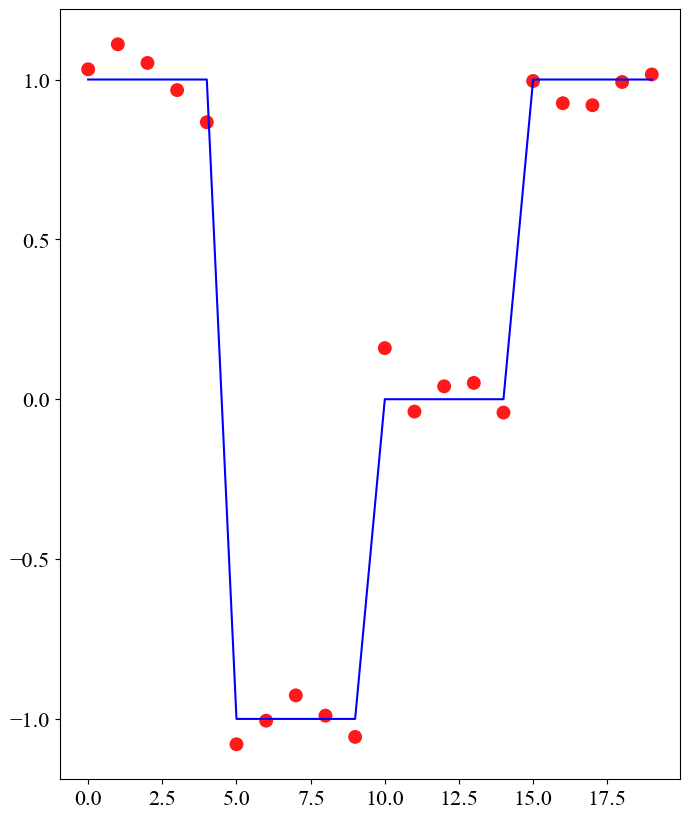

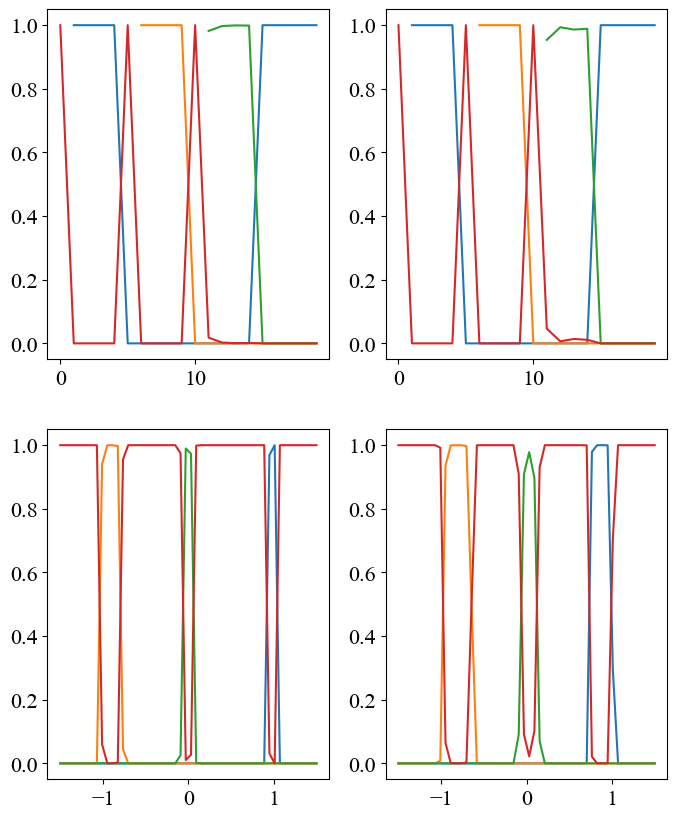

In [14]:
# ------- Contextual Comparison - Noisy vs Noiseless -------
data = np.concatenate([
    np.ones((5, )),
    -np.ones((5, )),
    np.zeros((5, )),
    np.ones((5, ))
])

state_values = np.linspace(-1.5, 1.5, 50)

# Noiseless COIN (small noise for algorithm to work)
coin_model = COIN(
    sigma_sensory_noise = 0.003, 
    sigma_motor_noise = 0.00182,
    prior_mean_retention=0.99,
)

coin_model.perturbations = data
output = coin_model.simulate_coin()

# Responsibilities - for training
known_c_resp, novel_c_resp = coin_model.get_responsibilities(output)
p_contexts = np.concatenate([known_c_resp,novel_c_resp[:,None]],axis=-1)
p_temp = p_contexts.copy()
p_temp[np.isnan(p_temp)] = 0.0
p_contexts[:,-1] = 1 - np.sum(p_temp[:,:-1], axis=1)

# Predicted responsibilities - for generalisation tests
pred_resp = coin_model.get_predicted_responsibilities(output, state_values)

# Noisy COIN
coin_model_noisy = COIN(
    sigma_sensory_noise = 0.06, 
    sigma_motor_noise = 0.0182,
    prior_mean_retention=0.99,
)

coin_model_noisy.perturbations = data
output_noisy = coin_model_noisy.simulate_coin()

# Get state feedback - True training values
feedback_values = output_noisy["runs"][0]["state_feedback"]

# Responsibilities - for training
known_c_resp_noisy, novel_c_resp_noisy = coin_model_noisy.get_responsibilities(output_noisy)
p_contexts_noisy = np.concatenate([known_c_resp_noisy,novel_c_resp_noisy[:,None]],axis=-1)
p_temp_noisy = p_contexts_noisy.copy()
p_temp_noisy[np.isnan(p_temp_noisy)] = 0.0
p_contexts_noisy[:,-1] = 1 - np.sum(p_temp_noisy[:,:-1], axis=1)

# Predicted responsibilities - for generalisation tests
pred_resp_noisy = coin_model_noisy.get_predicted_responsibilities(output_noisy, state_values)


# Plotting - Not in Paper
plt.figure(figsize=(8, 10))
plt.plot(data, label='True Data', color='blue')
plt.scatter(np.arange(feedback_values.size), feedback_values, alpha=0.9, edgecolor='none', color='red', s=100)


plt.figure(figsize=(8, 10))
plt.subplot(2, 2, 1)
plt.plot(p_contexts)
plt.subplot(2, 2, 2)
plt.plot(p_contexts_noisy)
plt.subplot(2,2,3)
plt.plot(state_values, pred_resp[:,-1,:])
plt.subplot(2,2,4)
plt.plot(state_values, pred_resp_noisy[:,-1,:])


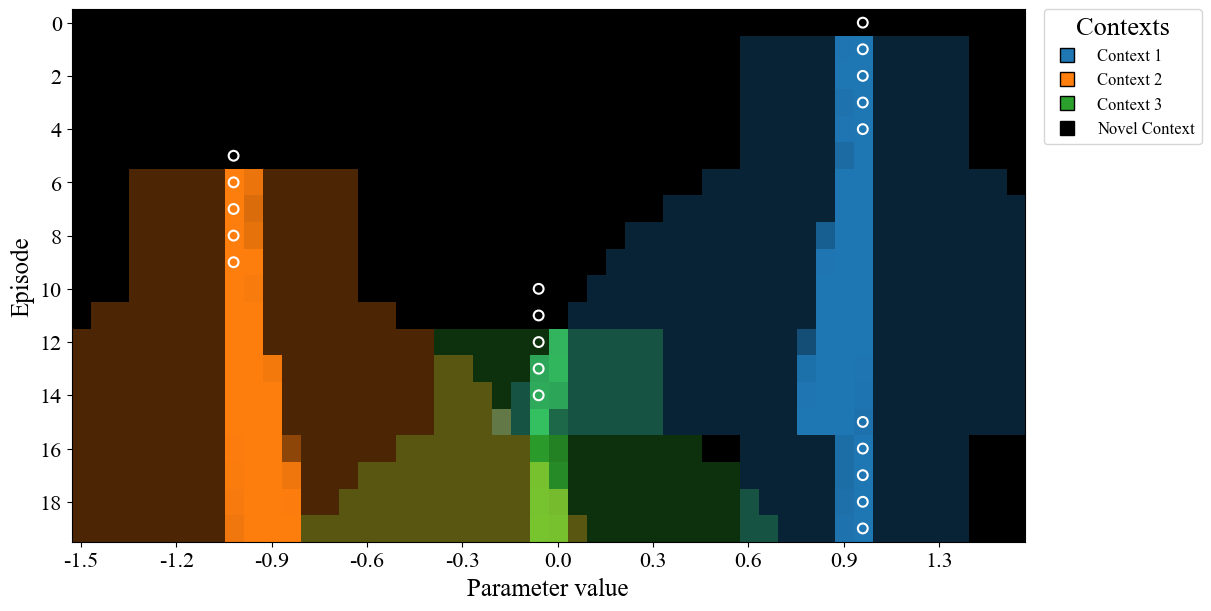

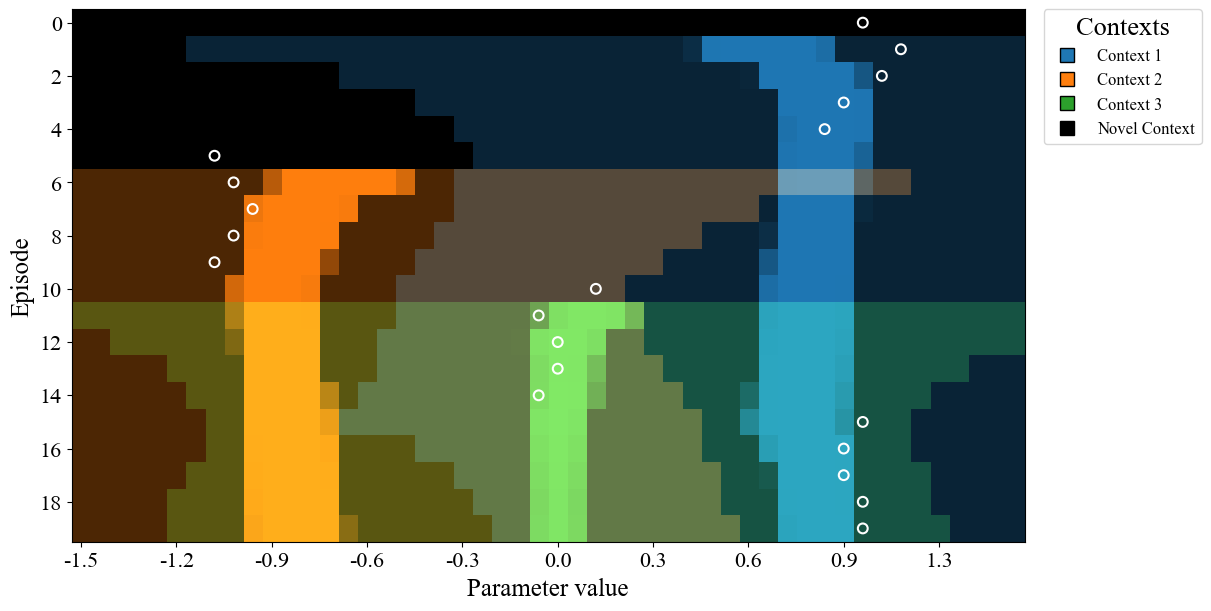

In [15]:
from utils.plot_utils import plot_context_probabilities

plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

ax1 = plot_context_probabilities(
    pred_resp,
    state_values,
    data,
    1,
    min_intensity = 0.3,
    fig_size=(12,6)
)

ax2 = plot_context_probabilities(
    pred_resp_noisy,
    state_values,
    feedback_values,
    1,
    min_intensity = 0.3,
    fig_size=(12,6)
)



In [8]:
def run_single_rep(data, p_context, gen_val, pred_resp, param_name='length'):
    """
    Runs one repetition of training across all data points. After every training step, evaluate for every 
    amplitude in gen_val.
    Returns the list of rewards for the evaluation steps.
    """
    # Imports for multiprocessing
    from environments import CustomCartPoleEnv
    from rl import COINPPOAgent
    import numpy as np
    from tqdm.notebook import tqdm

    # Write data to context-prob dictionary form
    data_dict = {}
    J = p_context.shape[1]-1 # number of contexts (excluding novel)
    for i in range(len(data)):
        data_dict[i] = {}
        for j in range(J):
            data_dict[i][j+1] = p_context[i,j]
        data_dict[i]['novel'] = p_context[i,-1]

    # Also write pred_resp to dictionary form
    pred_resp_dicts = []
    for i in range(pred_resp.shape[0]):
        pred_resp_dicts.append([])
        for t in range(pred_resp.shape[1]):
            pred_resp_dicts[i].append({})
            for j in range(J):
                pred_resp_dicts[i][t][j+1] = pred_resp[i,t,j]
            pred_resp_dicts[i][t]['novel'] = pred_resp[i,t,-1]

    kwargs = {param_name: 1.0}
    env = CustomCartPoleEnv(render_mode="none", **kwargs)
    agent = COINPPOAgent(base_obs_dim=4, act_dim=2, ctx_ids=data_dict[0].keys())

    rewards_for_this_rep = []
    training_rewards_for_this_rep = []
    evaluation_rewards_for_this_rep = []
    for epoch, param_val in tqdm(enumerate(data), total=len(data)):
        # Create the environment for each amplitude
        kwargs = {param_name: param_val}
        env = CustomCartPoleEnv(render_mode="none", **kwargs)

        # Set current context function
        context_fcn = lambda i: data_dict[epoch]

        r = agent.train_step(env, context_probs_fn=context_fcn) # Rollout steps here
        mean_return = r["mean_episode_return"]
        training_rewards_for_this_rep.append(mean_return)

        eval_r = agent.evaluate(env, context_probs_fn=context_fcn, n_episodes=1)[0]
        evaluation_rewards_for_this_rep.append(eval_r)
          
        # Evaluate for all the gen_val
        evaluation_rewards = np.zeros((gen_val.size,))

        for i in range(evaluation_rewards.size):
            kwargs = {param_name: gen_val[i]}
            env = CustomCartPoleEnv(render_mode="none", **kwargs)

            context_fcn = lambda x: pred_resp_dicts[i][epoch]
            evaluation_rewards[i] = np.mean(agent.evaluate(env, context_probs_fn=context_fcn, n_episodes=10, ignore_novel=True)[0])
        rewards_for_this_rep.append(evaluation_rewards)

    return np.stack(rewards_for_this_rep), np.stack(training_rewards_for_this_rep), np.stack(evaluation_rewards_for_this_rep)



In [17]:
REWARDS_PATH_NOISELESS = 'models/fig3b_rewards_noiseless.npy'
REWARDS_PATH_NOISY = 'models/fig3b_rewards_noisy.npy'
train_3c = False
if train_3c:
    all_results_noiseless = run_single_rep(data, p_contexts, state_values, pred_resp, param_name='gravity')

    rewards_noiseless = all_results_noiseless[0]

    # Save results
    np.save(REWARDS_PATH_NOISELESS, rewards_noiseless)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH_NOISELESS}'.")

    all_results_noisy = run_single_rep(feedback_values, p_contexts_noisy, state_values, pred_resp_noisy, param_name='gravity')
    rewards_noisy = all_results_noisy[0]

    # Save results
    np.save(REWARDS_PATH_NOISY, rewards_noisy)
    print(f"Training complete. Rewards saved to '{REWARDS_PATH_NOISY}'.")
        
else:
    # Load the saved results from the training
    if os.path.exists(REWARDS_PATH_NOISELESS):
        rewards_noiseless = np.load(REWARDS_PATH_NOISELESS)
        print(f"Loaded rewards from '{REWARDS_PATH_NOISELESS}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH_NOISELESS}'.")
    
    if os.path.exists(REWARDS_PATH_NOISY):
        rewards_noisy = np.load(REWARDS_PATH_NOISY)
        print(f"Loaded rewards from '{REWARDS_PATH_NOISY}'.")
    else:
        raise FileNotFoundError(f"No saved rewards found at '{REWARDS_PATH_NOISY}'.")

Loaded rewards from 'models/fig3b_rewards_noiseless.npy'.
Loaded rewards from 'models/fig3b_rewards_noisy.npy'.


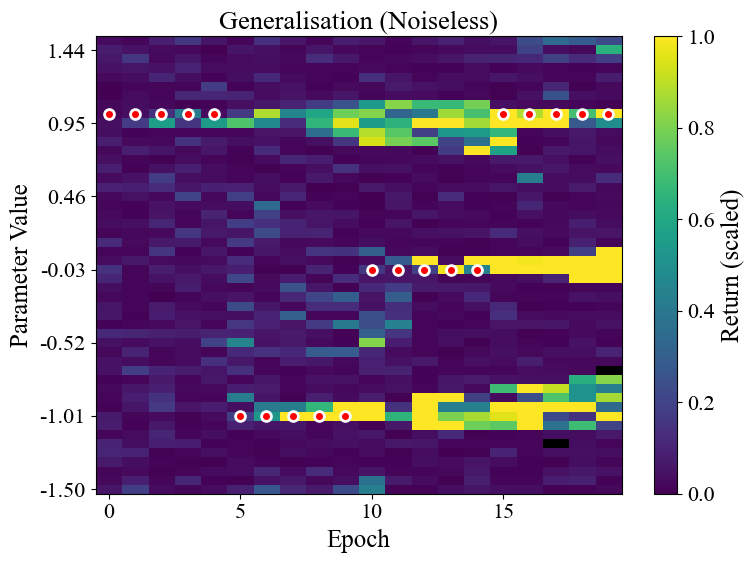

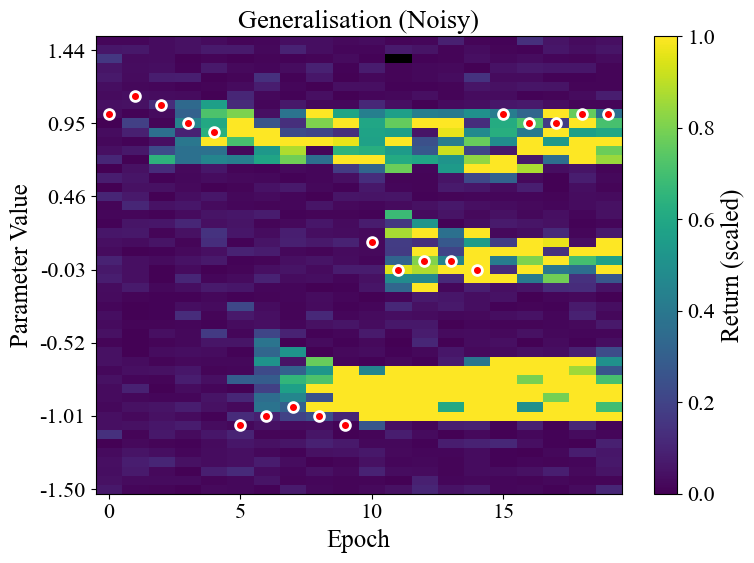

Noiseless max reward: 500.0
Noisy max reward: 500.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ─── Global style ───────────────────────────────────────────────────────────
plt.rcParams.update({
    "font.family": "Times New Roman",
    "font.size": 19,
    "axes.titlesize": 19,
    "axes.labelsize": 18,
    "legend.fontsize": 12,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16
})

def plot_return_heatmap(
    rewards: np.ndarray,
    feedback: np.ndarray,
    state_values: np.ndarray,
    xtick_step: int,
    ytick_step: int,
    filename: str,
    title: str = ""
):
    """
    Plot a heatmap of scaled returns over epochs vs. parameter values,
    with masked zeros shown in black and training feedback overlaid.

    Parameters
    ----------
    rewards : array, shape (n_epochs, n_params)
        Raw return values for each epoch/parameter.
    feedback : array, shape (n_epochs,)
        The “true” parameter value at each epoch (for scatter overlay).
    state_values : array, shape (n_params,)
        The full sweep of parameter values.
    xtick_step : int
        Step between epoch tick marks.
    ytick_step : int
        Step between parameter-value tick marks.
    filename : str
        Path under which to save the figure (SVG format).
    title : str, optional
        Figure title (displayed at top of axes).
    """
    # 1. normalize and mask zeros
    norm = (rewards - rewards.min()) / (rewards.max() - rewards.min())
    masked = np.ma.masked_where(norm == 0, norm)

    # 2. transpose so params→rows, epochs→cols
    heat = masked.T  # shape (n_params, n_epochs)
    n_params, n_epochs = heat.shape

    # 3. prepare colormap
    cmap = plt.get_cmap("viridis").copy()
    cmap.set_bad(color="black")

    # 4. plot
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(
        heat,
        origin="lower",
        aspect="auto",
        interpolation="nearest",
        vmin=0, vmax=1,
        cmap=cmap
    )

    # 5. overlay feedback points
    x_idx = np.arange(n_epochs)
    y_idx = np.clip(
        np.rint((feedback - state_values.min()) /
                (state_values.max() - state_values.min()) *
                (n_params - 1)).astype(int),
        0, n_params - 1
    )
    ax.scatter(
        x_idx, y_idx,
        facecolors="red",
        edgecolors="white",
        s=50, linewidths=2, marker="o"
    )

    # 6. labels, ticks, colorbar
    if title:
        ax.set_title(title)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Parameter Value")

    ax.set_xticks(np.arange(0, n_epochs, xtick_step))
    ax.set_xticklabels(np.arange(0, rewards.shape[0], xtick_step))

    ax.set_yticks(np.arange(0, n_params, ytick_step))
    ax.set_yticklabels([f"{v:.2f}" for v in state_values[::ytick_step]])

    fig.colorbar(im, ax=ax, label="Return (scaled)")
    plt.tight_layout()
    fig.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


# ─── Usage ─────────────────────────────────────────────────────────────────

# 1) Noiseless rewards
plot_return_heatmap(
    rewards=rewards_noiseless,
    feedback=data,
    state_values=state_values,
    xtick_step=5,
    ytick_step=8,
    filename="figures/fig3b_noiseless.svg",
    title="Generalisation (Noiseless)"
)

# 2) Noisy rewards
plot_return_heatmap(
    rewards=rewards_noisy,
    feedback=feedback_values,
    state_values=state_values,
    xtick_step=5,
    ytick_step=8,
    filename="figures/fig3b_noisy.svg",
    title="Generalisation (Noisy)"
)

# Print maximum rewards - For normalisation verification (If both are 500, then normalisation can be compared without bias)
print("Noiseless max reward:", rewards_noiseless.max())
print("Noisy max reward:", rewards_noisy.max())
